In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path
import random
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import figure, save_factory, PlotConfig, format_plots, ONTOGENY_AGE_CMAP, add_identity, legend
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
format_plots()
c = PlotConfig()

In [4]:
import numpy as np

import scipy
from scipy import stats

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from umap import UMAP
from sklearn.metrics import pairwise_distances

from pathlib import Path

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distanc

In [5]:
sns.set(font_scale=1.25, style="ticks", context="notebook", palette="tab10")

In [6]:
## create mouse map
nage=6 #number of age groups
nmice=16
keep_mice = [
    "_01_01",
    "_01_02",
    "_01_03",
    "_01_04",
    "_02_01",
    "_02_02",
    "_02_03",
    "_02_04",
    "_03_01",
    "_03_02",
    "_03_03",
    "_03_04",
    "_04_01",
    "_04_02",
    "_04_03",
    "_04_04",
] * nage
ages = np.repeat(['4','8','12','52','78','90'],nmice)
mouse_id = [x + y for x, y in zip(ages, keep_mice)]
samples = list(range(1,nage*nmice+1))
mapping = {key: value for key, value in zip(samples, mouse_id)}

In [7]:
## upload the raw beta file and sample table and ID

In [8]:
base_folder = Path("/n/groups/datta/win/longtogeny/data/epigenetics/analysis")

In [9]:
df_sample_mean = pd.read_csv(
    "/n/groups/datta/win/longtogeny/data/epigenetics/Datta_Project_001/Datta_Project_001/Datta_Project_001_Samples_Table.txt", sep="\t"
)

In [10]:
df = pd.read_csv(
    "/n/groups/datta/win/longtogeny/data/epigenetics/Datta_Project_001/Datta_Project_001/Datta_Project_001_Sample_Methylation_Profile.txt", sep="\t"
)

/tmp/ipykernel_27480/4165350121.py:1: DtypeWarning: Columns (4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,38,40,42,44,46,48,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [11]:
df["target_type"] = df.TargetID.str[:2]
df_subset = df[df.target_type == "cg"].copy()

# uploads normalized and corrected betas from sesame script in R

In [12]:
# opload prediction of age from epigenetic clock zou 2022 as applied by sesame
df_age_pred = pd.read_csv(base_folder / "age_prediction.csv", index_col=0)
df_age_pred["weeks"] = df_age_pred["outs"] * 4
weeks = [4, 8, 12, 52, 78, 90]
array_week = np.array(weeks)

In [13]:
# upload normzlized and corrected beta values as calculated by r script sesame
df_beta = pd.read_csv(base_folder / "betas_mat.csv.gz", index_col=0)

In [14]:
# arrange data and run PCA
df_keep = df_beta[~df_beta.isnull().any(axis=1)]
X_mat = df_keep.values.T
print(X_mat.shape)

pca = PCA(n_components=20).fit(X_mat)
X_pca = pca.transform(X_mat)

(24, 275573)


In [15]:
#seperate the array name from the raw-column id. to be used later to map location on chip to mouse id
df_meta = pd.DataFrame(
    df_keep.columns.str.split("_").tolist(),
    columns=["array", "rc"],
    index=df_keep.columns,
)

In [16]:
# to map mouse id to location on plate
df_sample_mean.columns = df_sample_mean.columns.map(lambda l: l.replace(" ", "_"))
df_sample_mean["array"] = df_sample_mean["Sentrix_Barcode"].astype(str).copy()

In [17]:
# match mouse/sampel id to array location, add chronolocal age information
# df_meta_merge matches sample id with all kinds of meta data such as chip. r-c location and intensity measures.  
df_meta_merge = (
    df_meta.reset_index()
    .merge(
        df_sample_mean,
        left_on=["array", "rc"],
        right_on=["array", "Sample_Section"],
        how="left",
    )
    .set_index("index")
)
df_meta_merge["age"] = array_week[
    np.floor(((df_meta_merge["Index"] - 1) / 4)).astype(int)
]
df_meta_merge["age_cat"] = pd.Categorical(df_meta_merge.age, categories=weeks)

assert df_keep.columns.equals(df_meta_merge.index)

In [18]:
## add mouse identification to df_meta_merge
df_meta_merge['mouse_id'] = df_meta_merge['Sample_ID']
df_meta_merge['mouse_id'] = df_meta_merge['mouse_id'].map(mapping)
dna_meta = df_meta_merge[['age_cat','mouse_id','Sentrix_Barcode']]

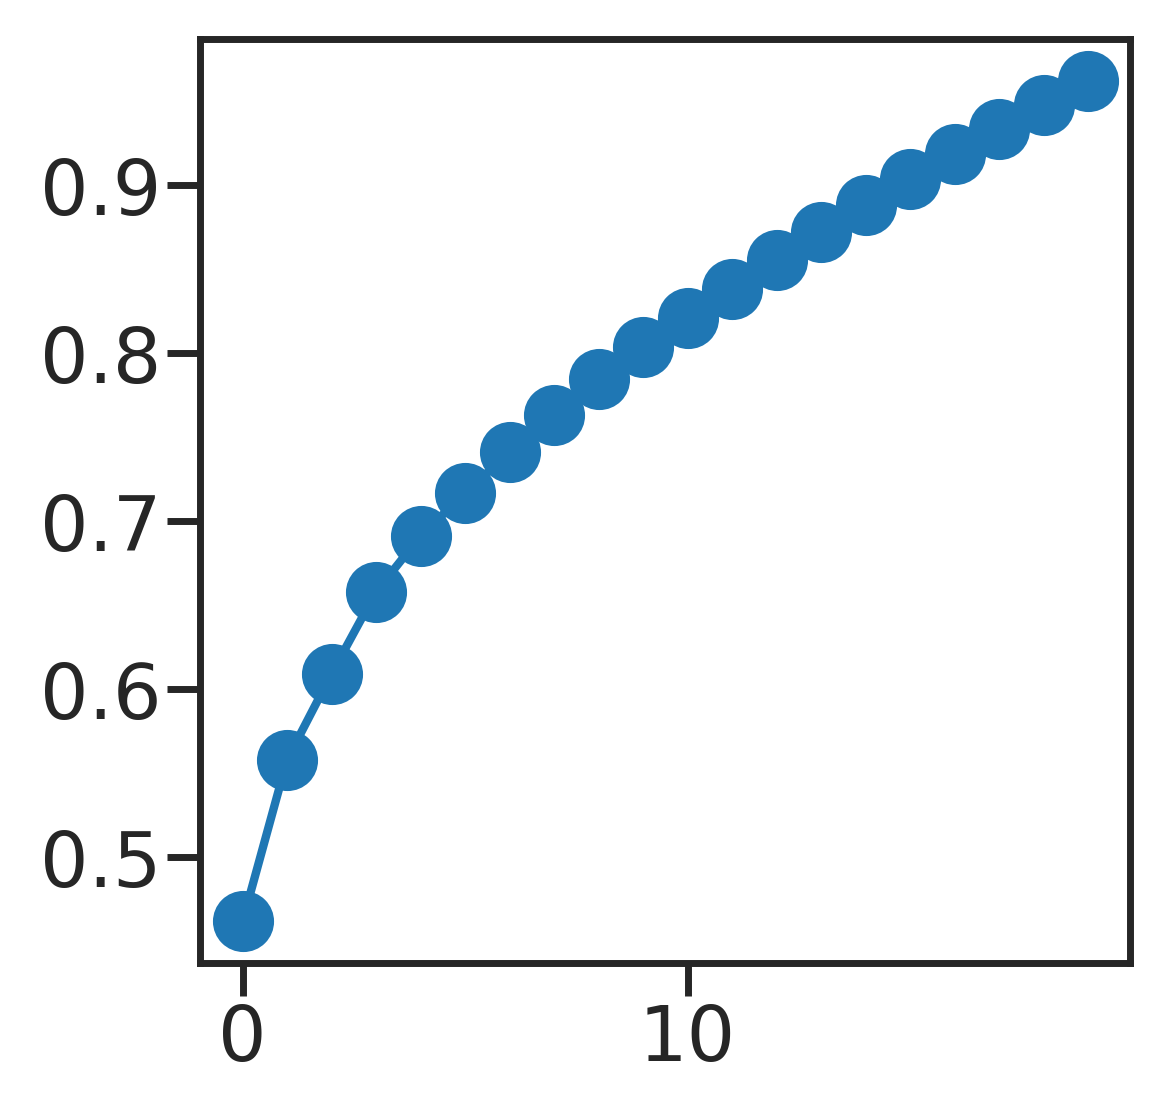

In [19]:
fig, ax = plt.subplots()
plt.plot(np.cumsum(pca.explained_variance_ratio_), '.-', ms=20)

In [20]:
df_pca = pd.DataFrame(X_pca, index=df_keep.columns)
#df_pca_merge = df_pca.join(df_meta_merge)
df_pca_merge = df_pca.join(dna_meta)

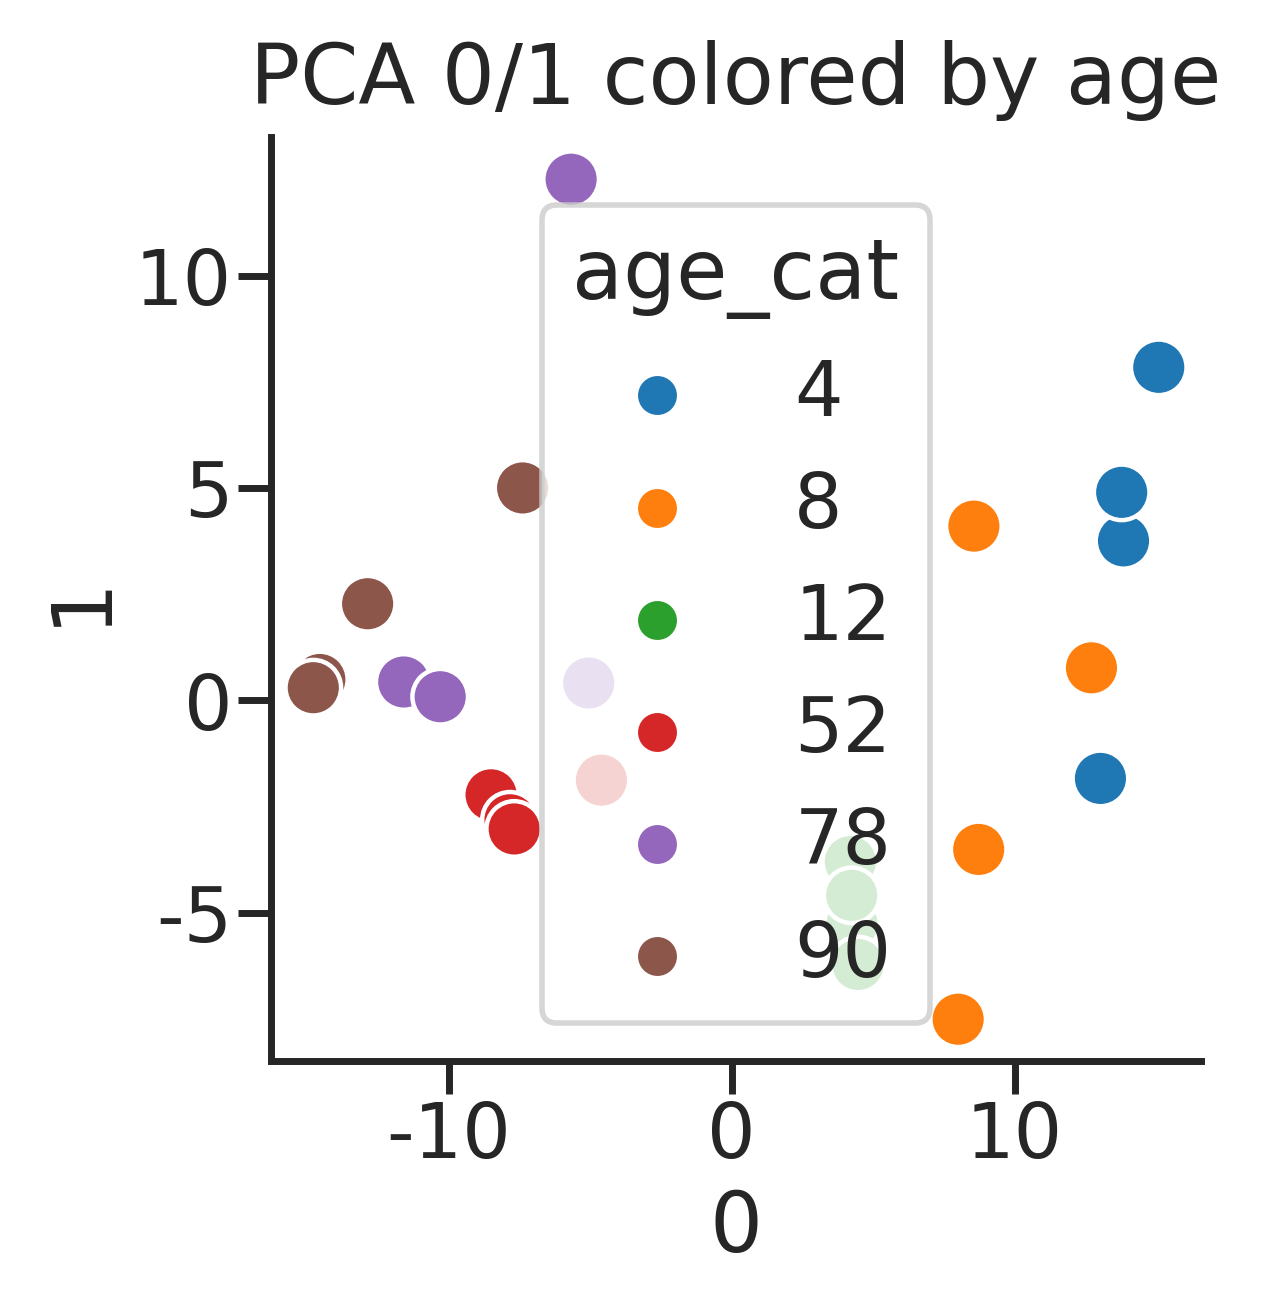

In [21]:
fig, ax = plt.subplots()
sns.scatterplot(df_pca_merge, x=0, y=1, hue="age_cat", s=100)
ax.set_title ('PCA 0/1 colored by age')
sns.despine()

In [22]:
# sort the label id by the actual age order
##IMPORATN! MAYBE ALSO SORT BY MOUSE id"
age_order = df_meta_merge.sort_values(['age_cat', 'Index']).index

In [23]:
df_meta_merge

,array,rc,%_Loci_Detected,Index,Sample_ID,Sample_Group,Sentrix_Barcode,Sample_Section,Detected_CpG_(0.01),Detected_CpG_(0.05),...,Signal_P75_GRN,Signal_P75_RED,Signal_P95_GRN,Signal_P95_RED,Sample_Well,Sample_Plate,Pool_ID,age,age_cat,mouse_id
index,,,,,,,,,,,,,,,,,,,,,
207723860044_R01C01,207723860044,R01C01,99.98398,1,1,1,207723860044,R01C01,286976,287004,...,4120,3235,6334,5938,A01,Datta_Sample_001,NaN,4,4,4_01_01
207723860044_R01C02,207723860044,R01C02,99.97701,7,25,25,207723860044,R01C02,286919,286984,...,3967,3109,6379,5982,G01,Datta_Sample_001,NaN,8,8,8_03_01
207723860044_R02C01,207723860044,R02C01,99.98119,2,7,7,207723860044,R02C01,286932,286996,...,4323,3348,7194,6649,B01,Datta_Sample_001,NaN,4,4,4_02_03
207723860044_R02C02,207723860044,R02C02,99.98746,8,32,32,207723860044,R02C02,286985,287014,...,4803,3566,7472,6658,H01,Datta_Sample_001,NaN,8,8,8_04_04
207723860044_R03C01,207723860044,R03C01,99.98990,3,9,9,207723860044,R03C01,287003,287021,...,4821,3603,7567,6711,C01,Datta_Sample_001,NaN,4,4,4_03_01
207723860044_R03C02,207723860044,R03C02,99.99094,9,34,34,207723860044,R03C02,287001,287024,...,4586,3527,7296,6588,A02,Datta_Sample_001,NaN,12,12,12_01_02
207723860044_R04C01,207723860044,R04C01,99.98502,4,15,15,207723860044,R04C01,286973,287007,...,4713,3354,7430,6327,D01,Datta_Sample_001,NaN,4,4,4_04_03
207723860044_R04C02,207723860044,R04C02,99.97213,10,37,37,207723860044,R04C02,286923,286970,...,4740,3199,7481,6047,B02,Datta_Sample_001,NaN,12,12,12_02_01
207723860044_R05C01,207723860044,R05C01,99.98293,5,17,17,207723860044,R05C01,286981,287001,...,5381,3611,8444,6782,E01,Datta_Sample_001,NaN,8,8,8_01_01


In [24]:
df_pca_corr = df_pca.T[age_order].corr()

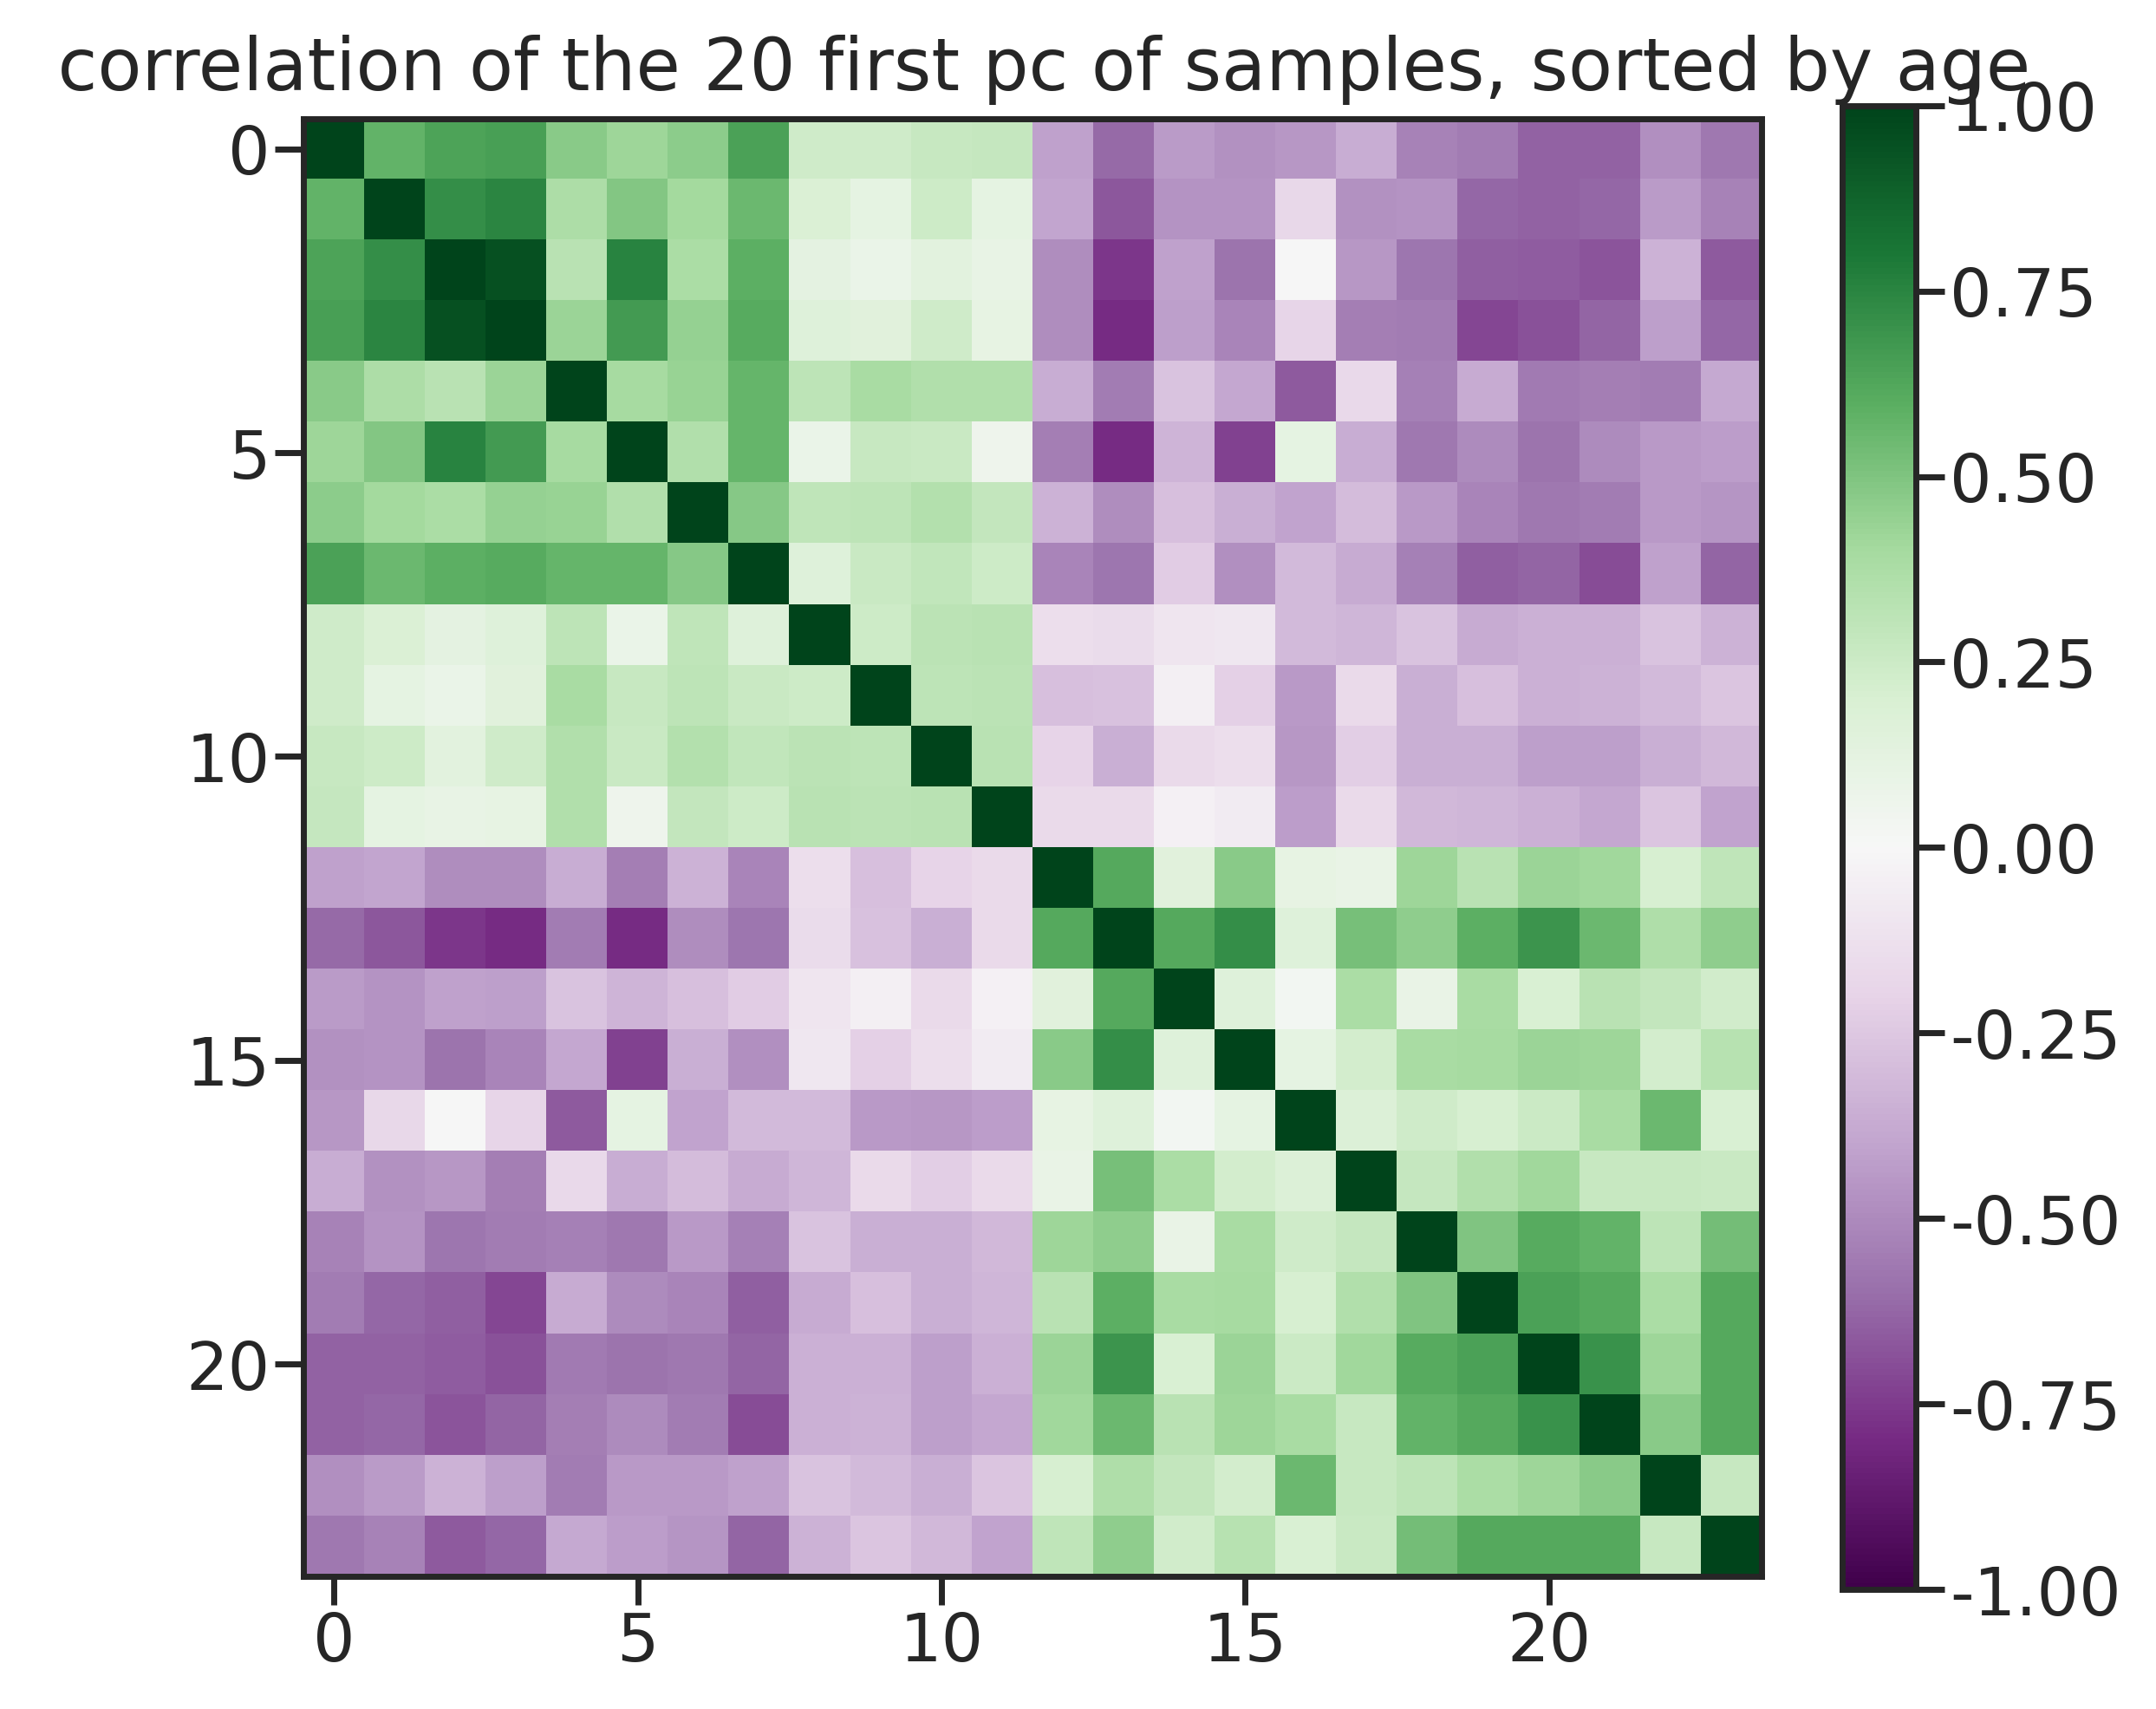

In [25]:
# plot the oc correlation between different mice, sorted by age order
df_pca_corr = df_pca.T[age_order].corr()
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(df_pca_corr, aspect="auto", vmin=-1, vmax=1, cmap="PRGn")
ax.set_box_aspect(1)
ax. set_title (' correlation of the 20 first pc of samples, sorted by age')
plt.colorbar(im, fraction=0.046)

UMAP(min_dist=0.25, verbose=True)
Mon Apr 15 11:07:30 2024 Construct fuzzy simplicial set
Mon Apr 15 11:07:31 2024 Finding Nearest Neighbors
Mon Apr 15 11:07:34 2024 Finished Nearest Neighbor Search
Mon Apr 15 11:07:37 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr 15 11:07:40 2024 Finished embedding


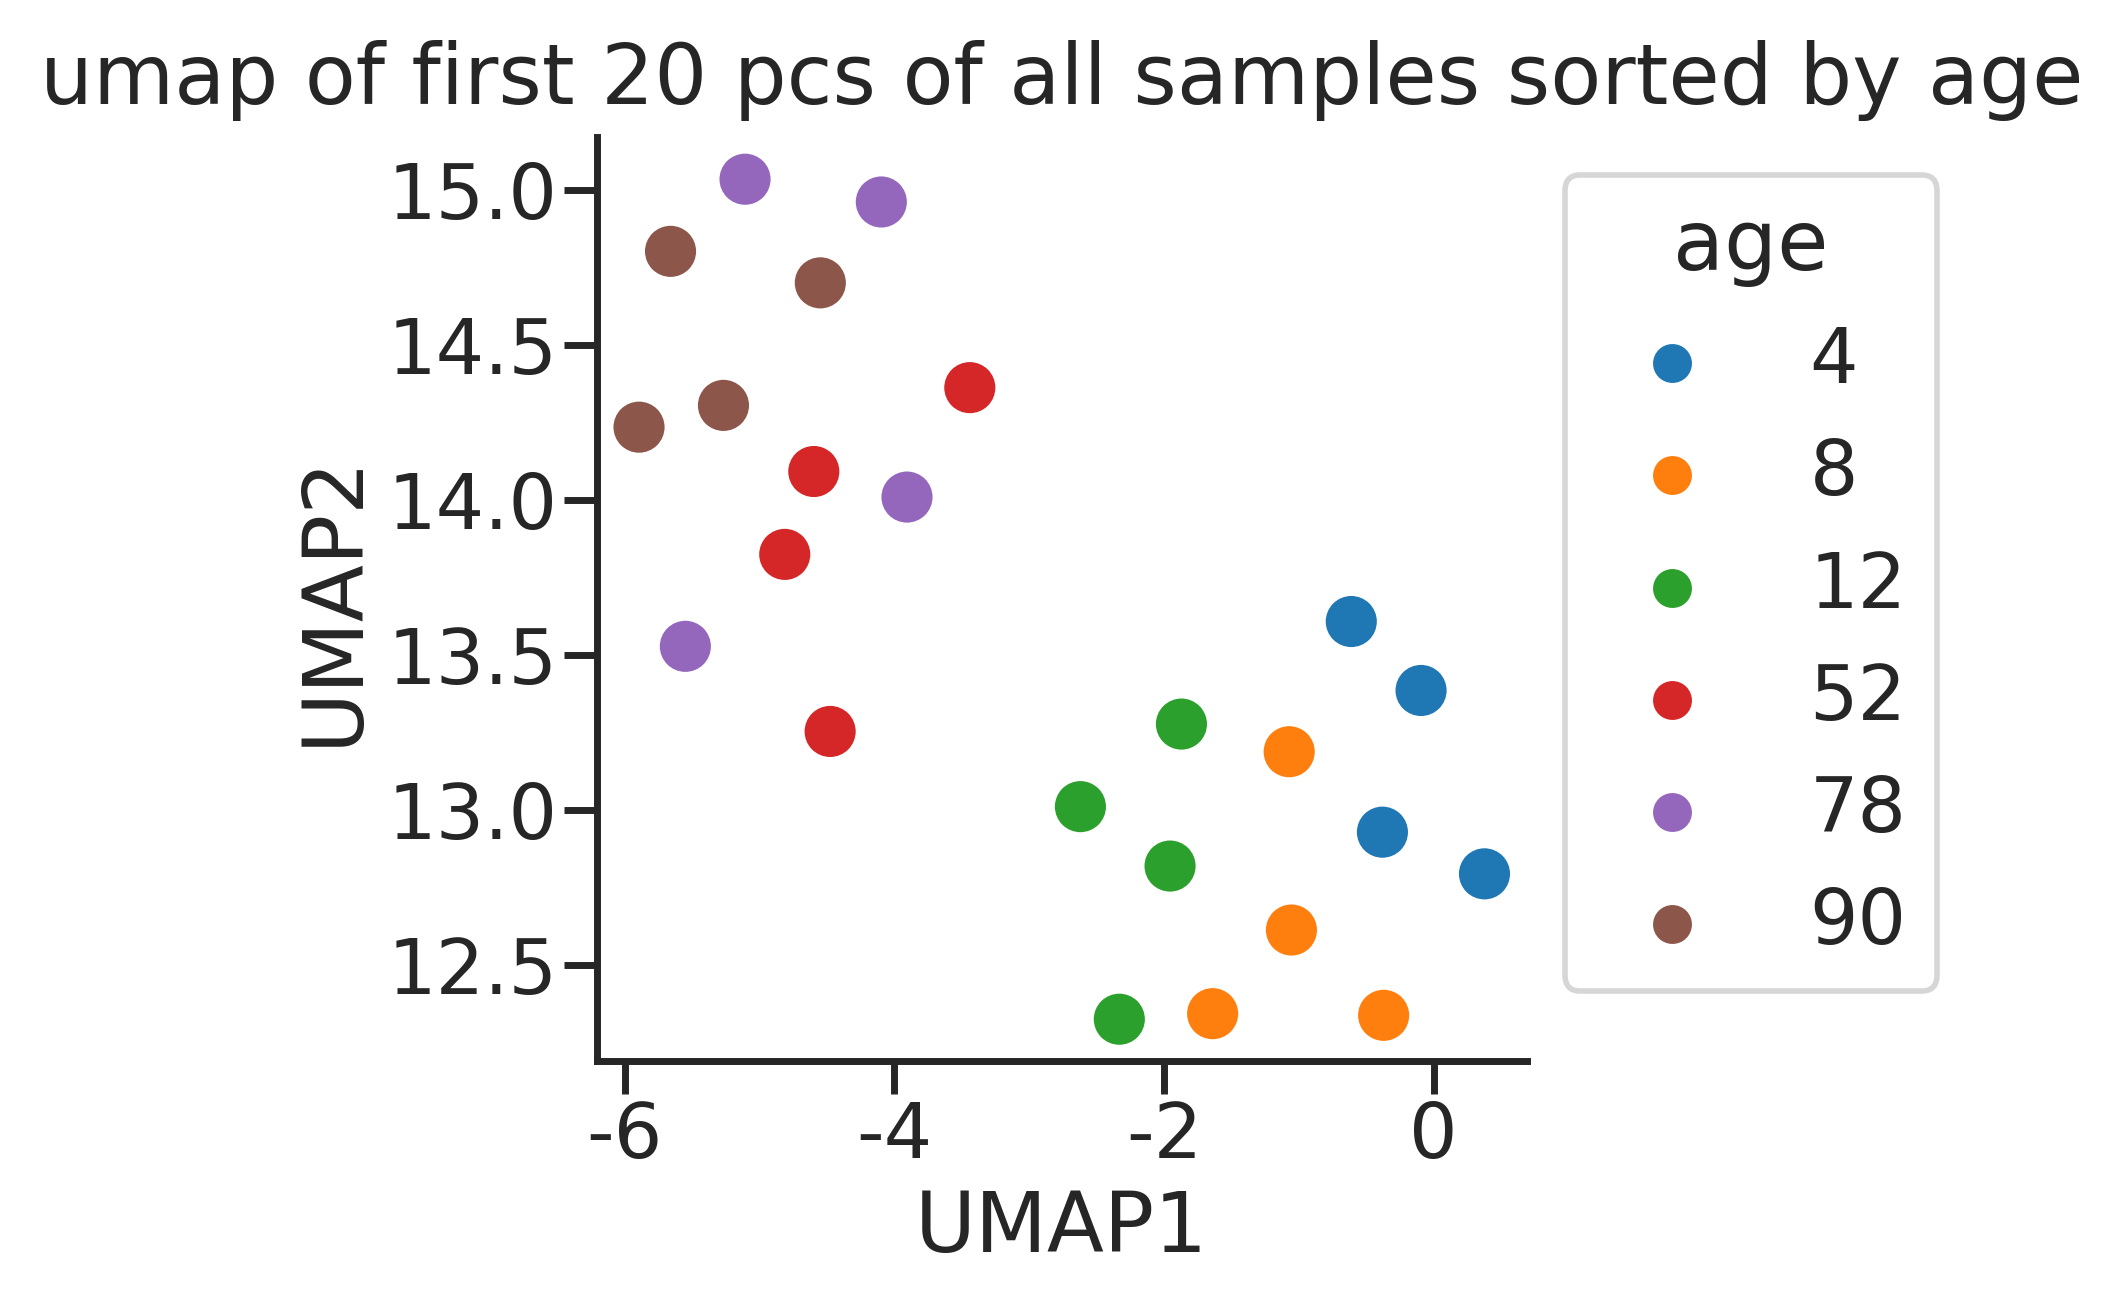

In [26]:
# also plot umap
X_umap = UMAP(n_components=2, min_dist=0.25, verbose=True).fit_transform(X_pca)
df_umap = pd.DataFrame(X_umap, index=df_keep.columns, columns=["UMAP1", "UMAP2"]).join(df_meta_merge)
fig, ax = plt.subplots()
sns.scatterplot(df_umap, x="UMAP1", y="UMAP2", hue="age_cat", s=100, ax=ax)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), title="age")
ax.set_title ('umap of first 20 pcs of all samples sorted by age')
sns.despine()

In [27]:
## find the loads of the differentct pc's on the actual methyl sites

In [28]:
df_comp = pd.DataFrame(pca.components_.T, index=df_keep.index)

In [29]:
# to look for specific probes that have the highest loads on pc 0 
df_comp[0].sort_values()

cg29611121_TC21   -0.018319
cg29611138_TC21   -0.014766
cg46354352_BC11   -0.014482
cg44695870_BC11   -0.013263
cg48206202_TC11   -0.012653
                     ...   
cg30292048_TC11    0.024060
cg33754067_TC11    0.024134
cg35931402_TC11    0.024392
cg30224278_BC11    0.025822
cg33797913_TC11    0.031224
Name: 0, Length: 275573, dtype: float64

In [30]:
# find one specific probe in all of our samples
pr="cg28977202_TC11"
df_meta_probe = df_meta_merge.join(df_keep.loc[pr].rename("probe"))

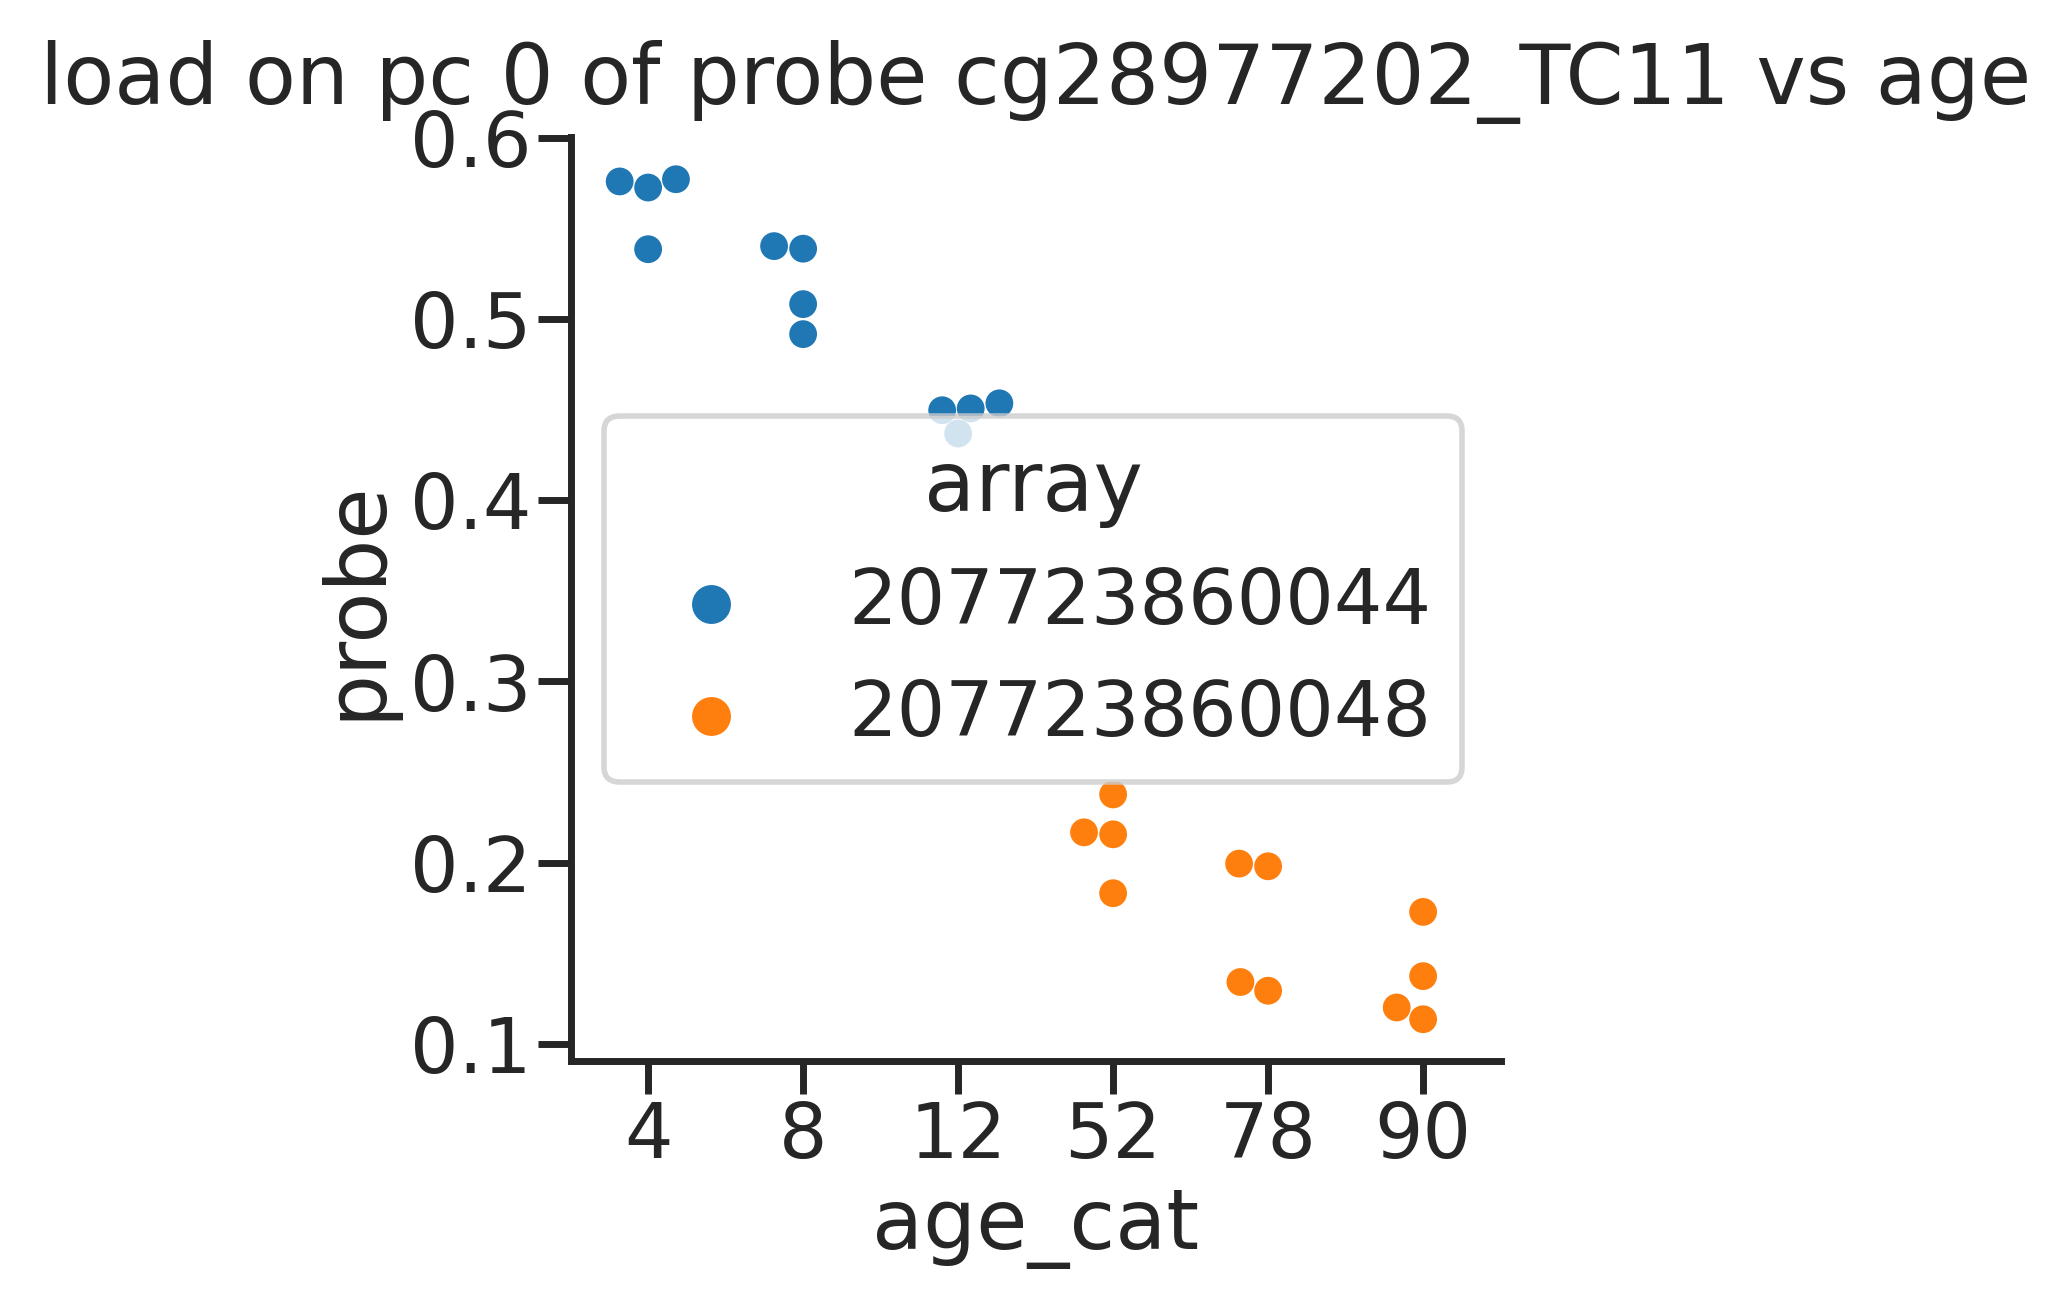

In [31]:
fig, ax = plt.subplots()
sns.swarmplot(data=df_meta_probe, x="age_cat", y="probe", hue="array")
ax.set_title('load on pc 0 of probe ' + pr + " vs age")
sns.despine()

In [32]:
## plot the loads of the 200 sites with the highest loads on pc 0 for the different samples

In [33]:
# find the 100 probes with the largerst loads on pc0 across all samples, avarage thier loads for each sample
df_probe_mean = df_keep.loc[df_comp[0].nlargest(100).index].mean().rename("probe")

In [34]:
# zscore the values from above and match to the age of the samples
df_probe_mean = (
    df_keep.loc[df_comp[0].nlargest(100).index]
    .T.apply(stats.zscore)
    .mean(1)
    .rename("probe")
)
df_meta_probe = df_meta_merge.join(df_probe_mean)

In [35]:
# make the colors to match the ages
week_map = dict(zip(weeks, plt.cm.tab10.colors))
df_anno = df_meta_merge.age.map(week_map)

In [36]:
# find the 200 sited with the abs(highest) load on pc 0 
top100 = df_comp[0].nlargest(100).index
bottom100 = df_comp[0].nsmallest(100).index
both = top100.append(bottom100)

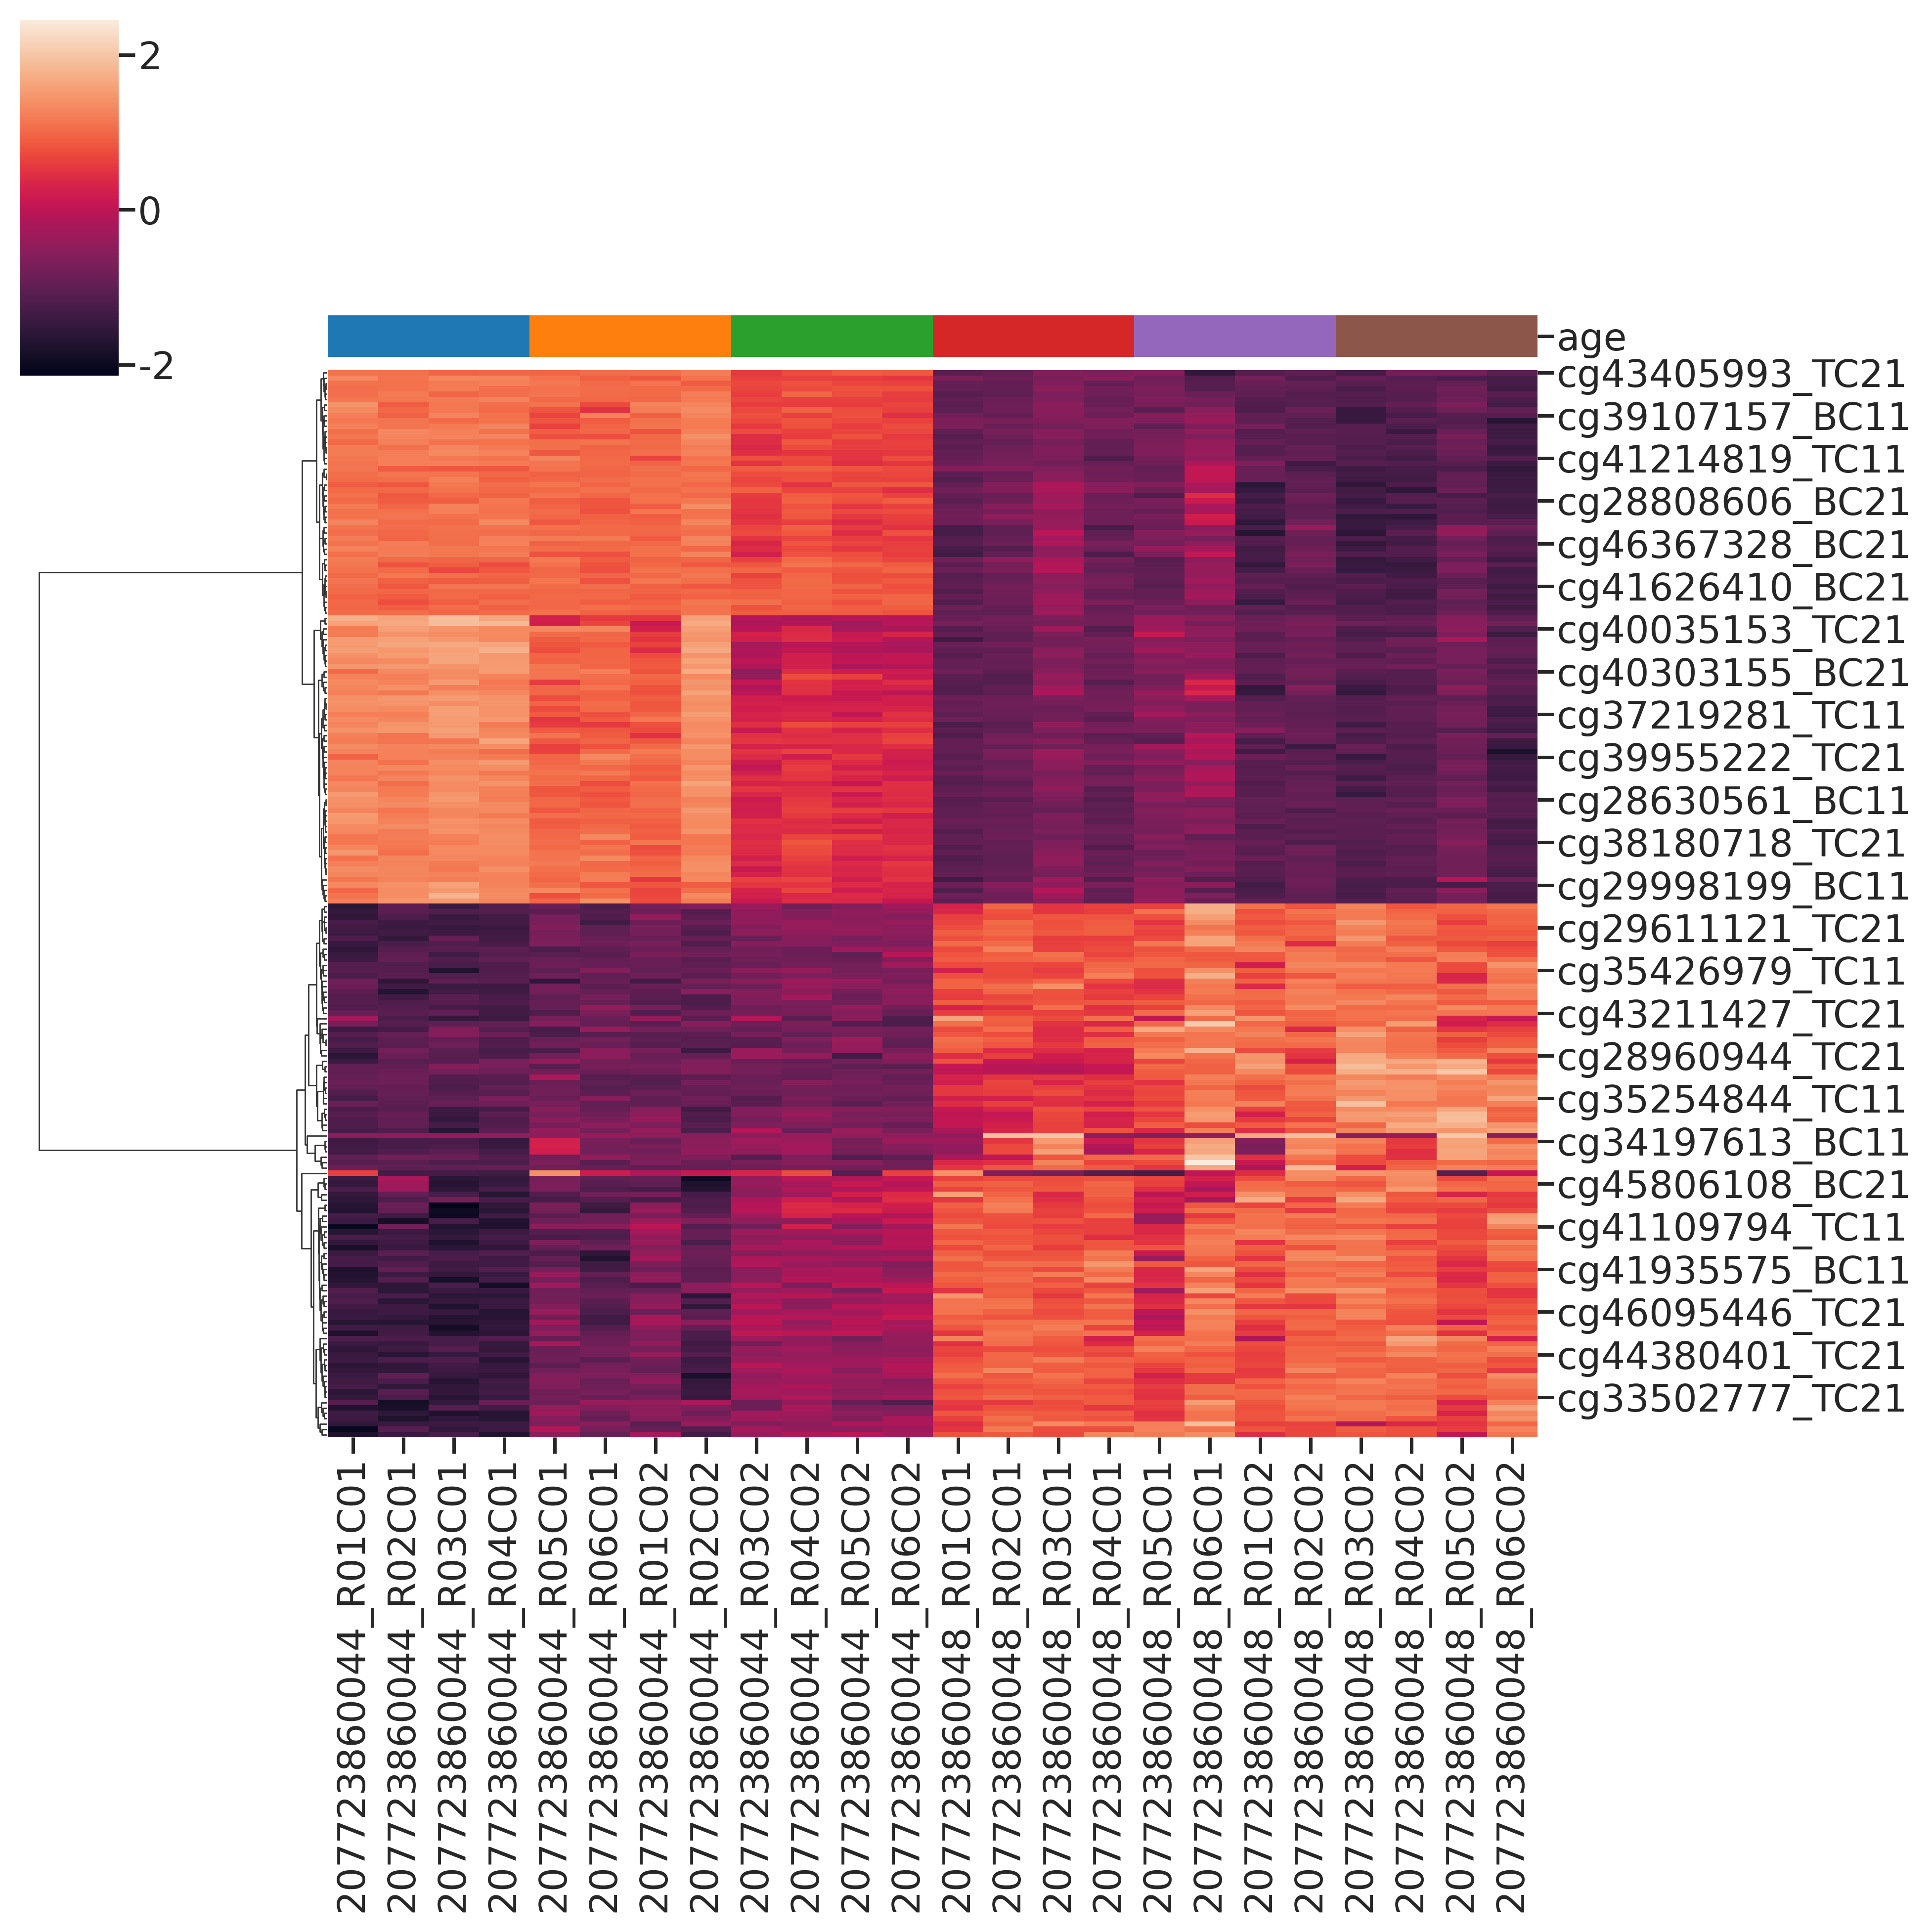

In [37]:
# plot loads for each of 200 sites for all samples
g = sns.clustermap(
    df_keep.loc[both][age_order],
    col_colors=df_anno,
    col_cluster=False,
    #row_cluster = False,
#     vmin=0, vmax=1,
    z_score=0,
    method="ward"
)

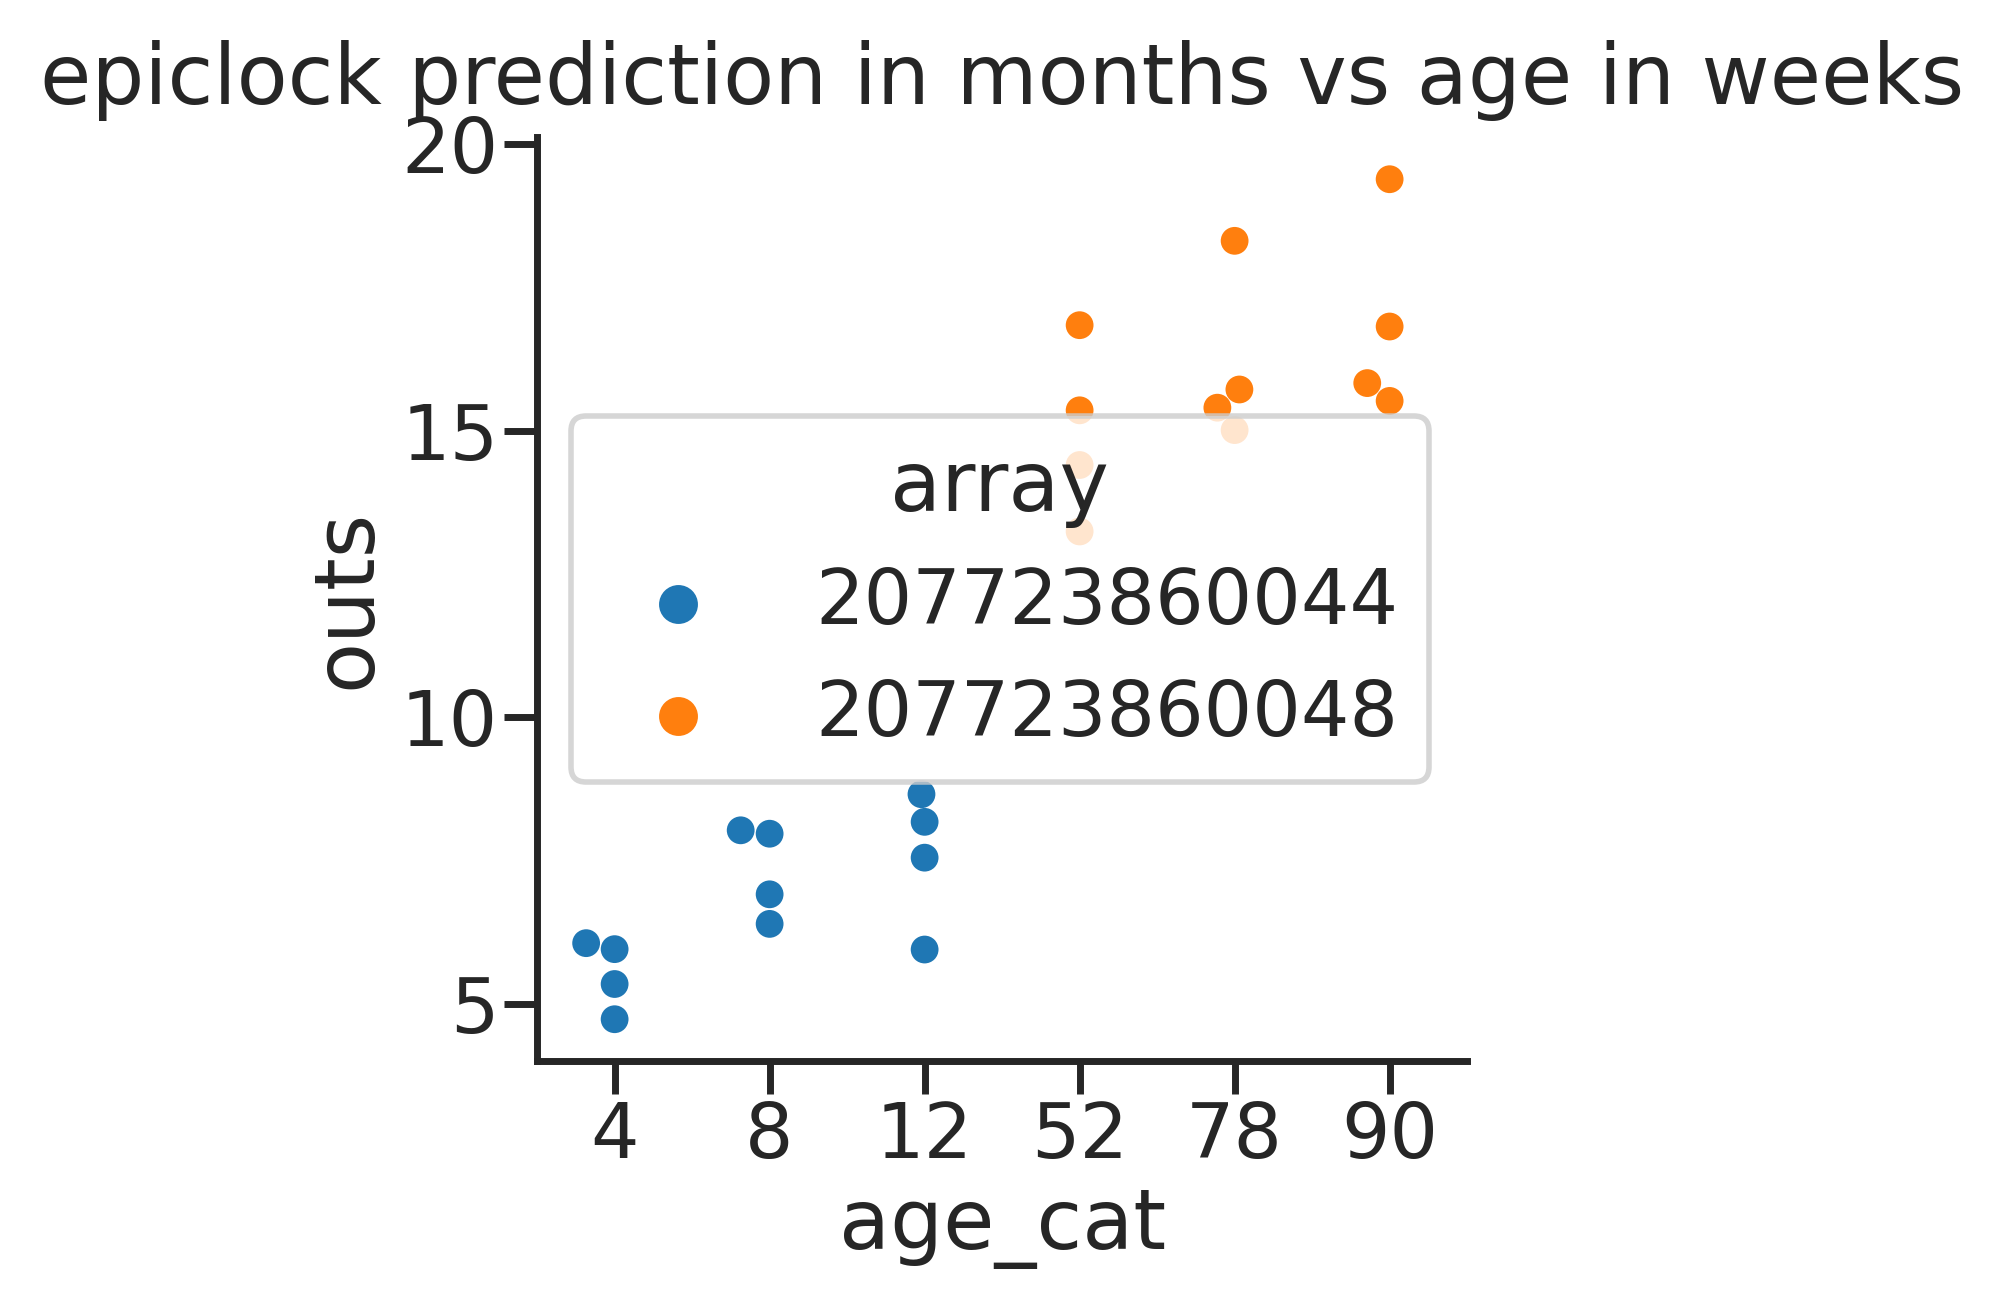

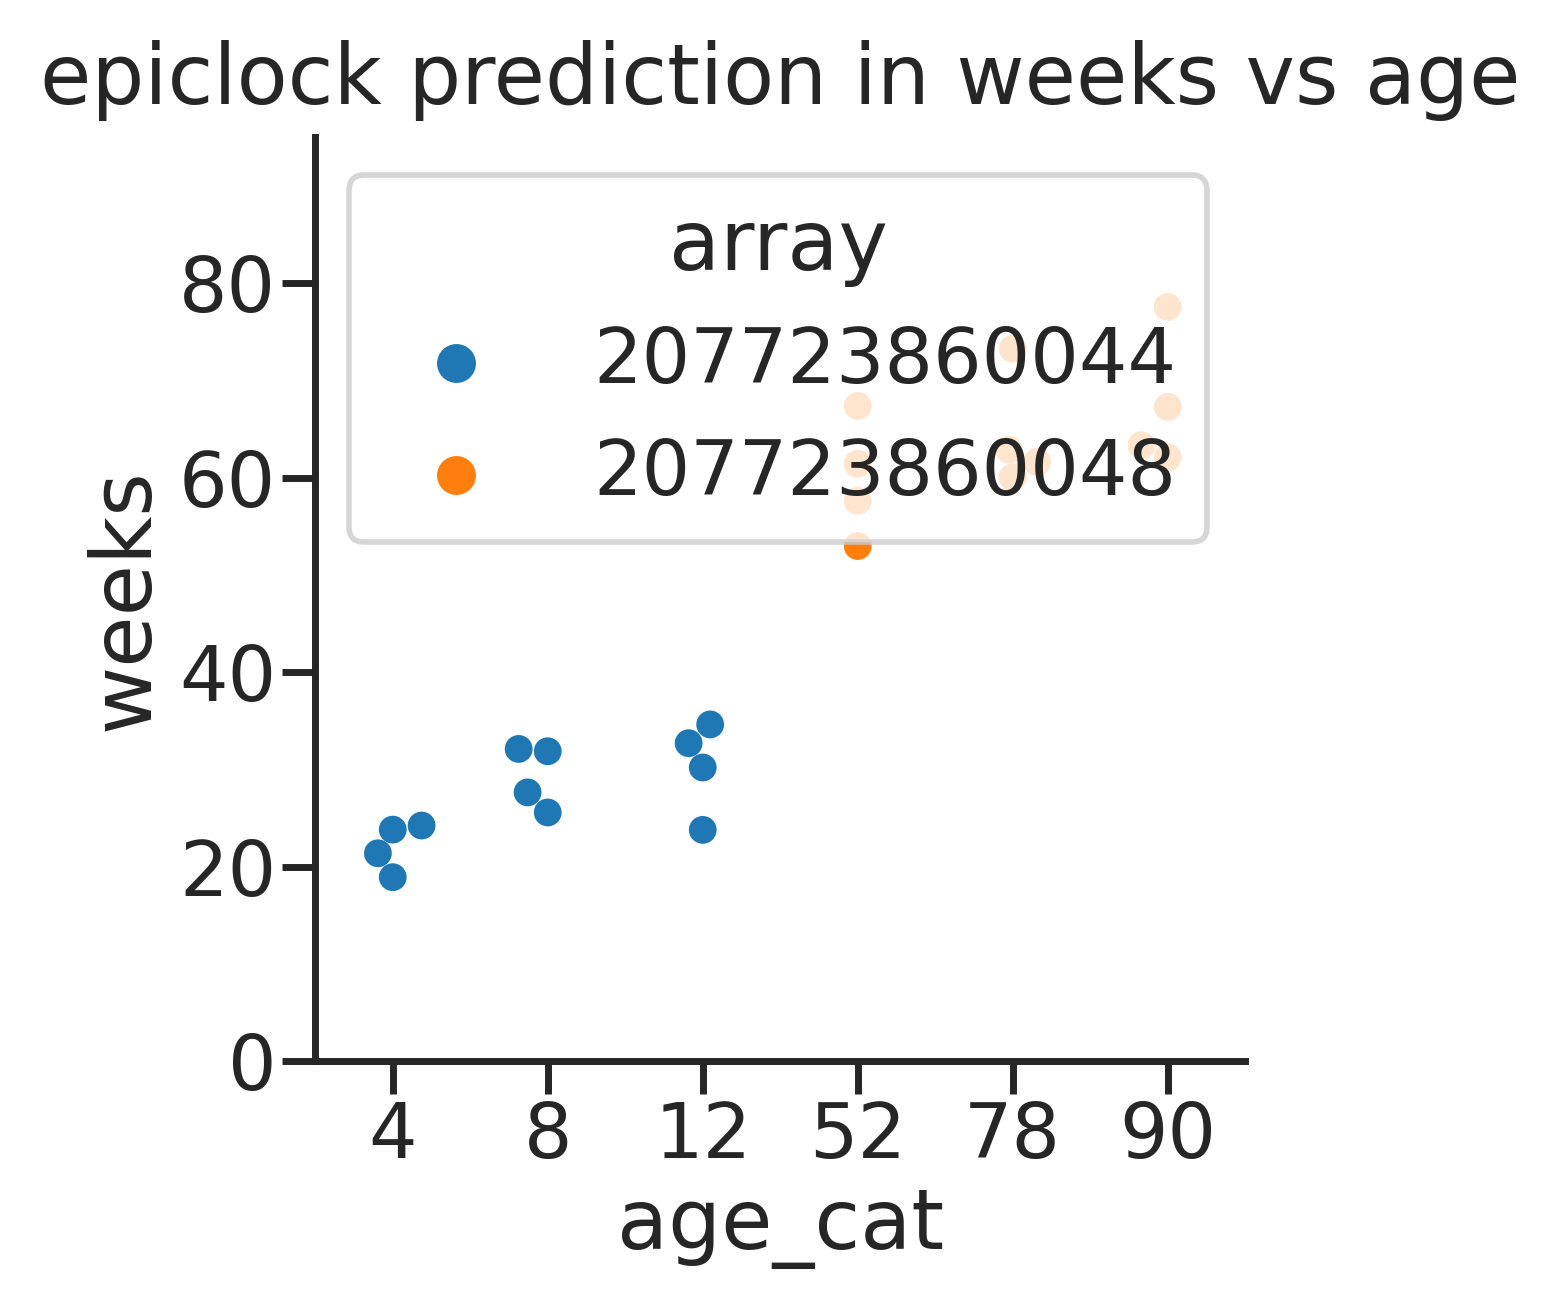

In [38]:
fig, ax = plt.subplots()
sns.swarmplot(data=df_age_pred.join(df_meta_merge), x="age_cat", y="outs", hue="array")
ax.set_title ('epiclock prediction in months vs age in weeks')
sns.despine()
fig, ax = plt.subplots()
sns.swarmplot(data=df_age_pred.join(df_meta_merge), x="age_cat", y="weeks", hue="array")
ax.set_title ('epiclock prediction in weeks vs age')
ax.set_ylim([0,95])
#ax.set_xlim([0,95])
sns.despine()

In [39]:
## compare with behavior

In [40]:
# load beahvioral data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_with_bioage_v00.parquet')
df = pd.read_parquet(path)

In [41]:
## update data
def filter_df(df):
    max=39
    n=16
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [42]:
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['bio_age','age','mouse','uuid',]).mean()
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]

In [43]:
#filter to find ages in age range of the epidata
fdata = data.reset_index()
fdata['mouse']=fdata['mouse'].str[-6:]
fdata['mouse_id'] = [x + y for x, y in zip(fdata['age'].astype(str), fdata['mouse'])]

In [44]:
# get just the mice who's id's are in the epigenetic samples
# get the pca matrix of the epigenetic data
df_pca_dna = df_pca_merge.copy()
df_pca_dna.set_index(['age_cat','mouse_id','Sentrix_Barcode'], inplace=True)
df_pca_dna.sort_index(inplace=True)
ids = df_pca_dna.index.get_level_values('mouse_id')

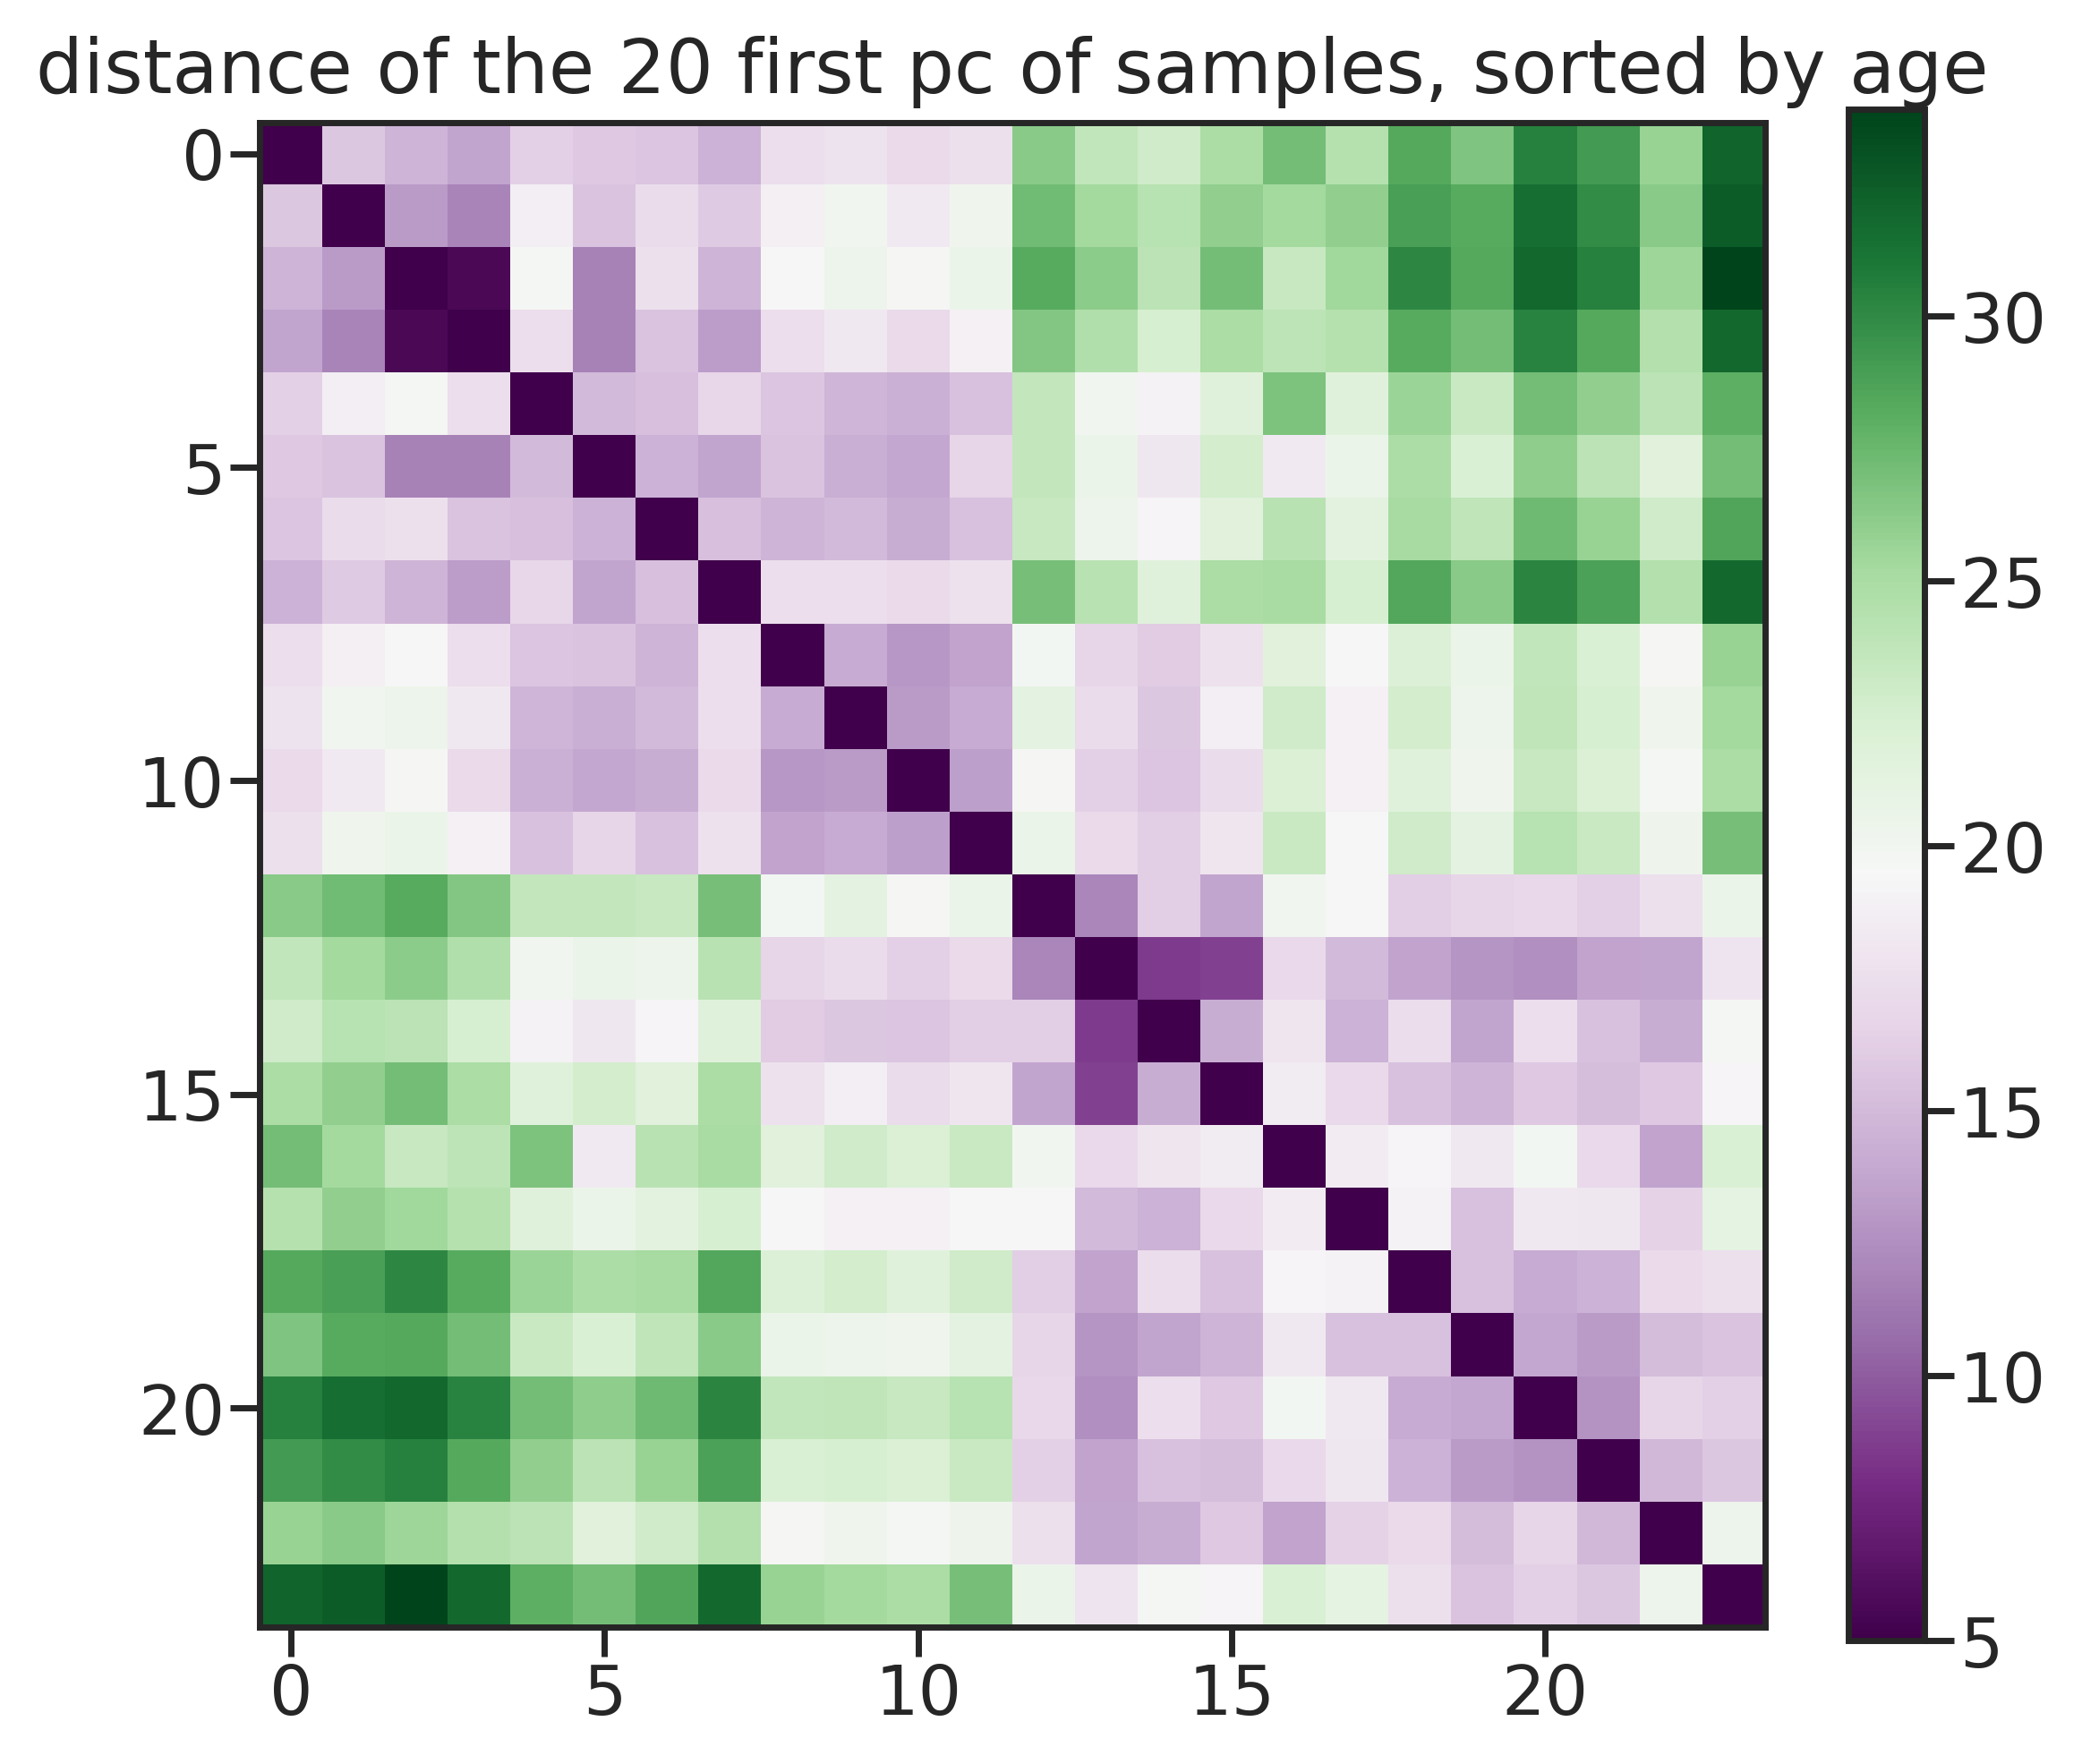

In [45]:
# plot the oc correlation between different mice, sorted by age order
dfd_pca_corr = pairwise_distances(df_pca_dna)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(dfd_pca_corr, aspect="auto", 
               vmin=5, 
               #vmax=1, 
               cmap="PRGn")
ax.set_box_aspect(1)
ax. set_title ('distance of the 20 first pc of samples, sorted by age')
plt.colorbar(im, fraction=0.046)

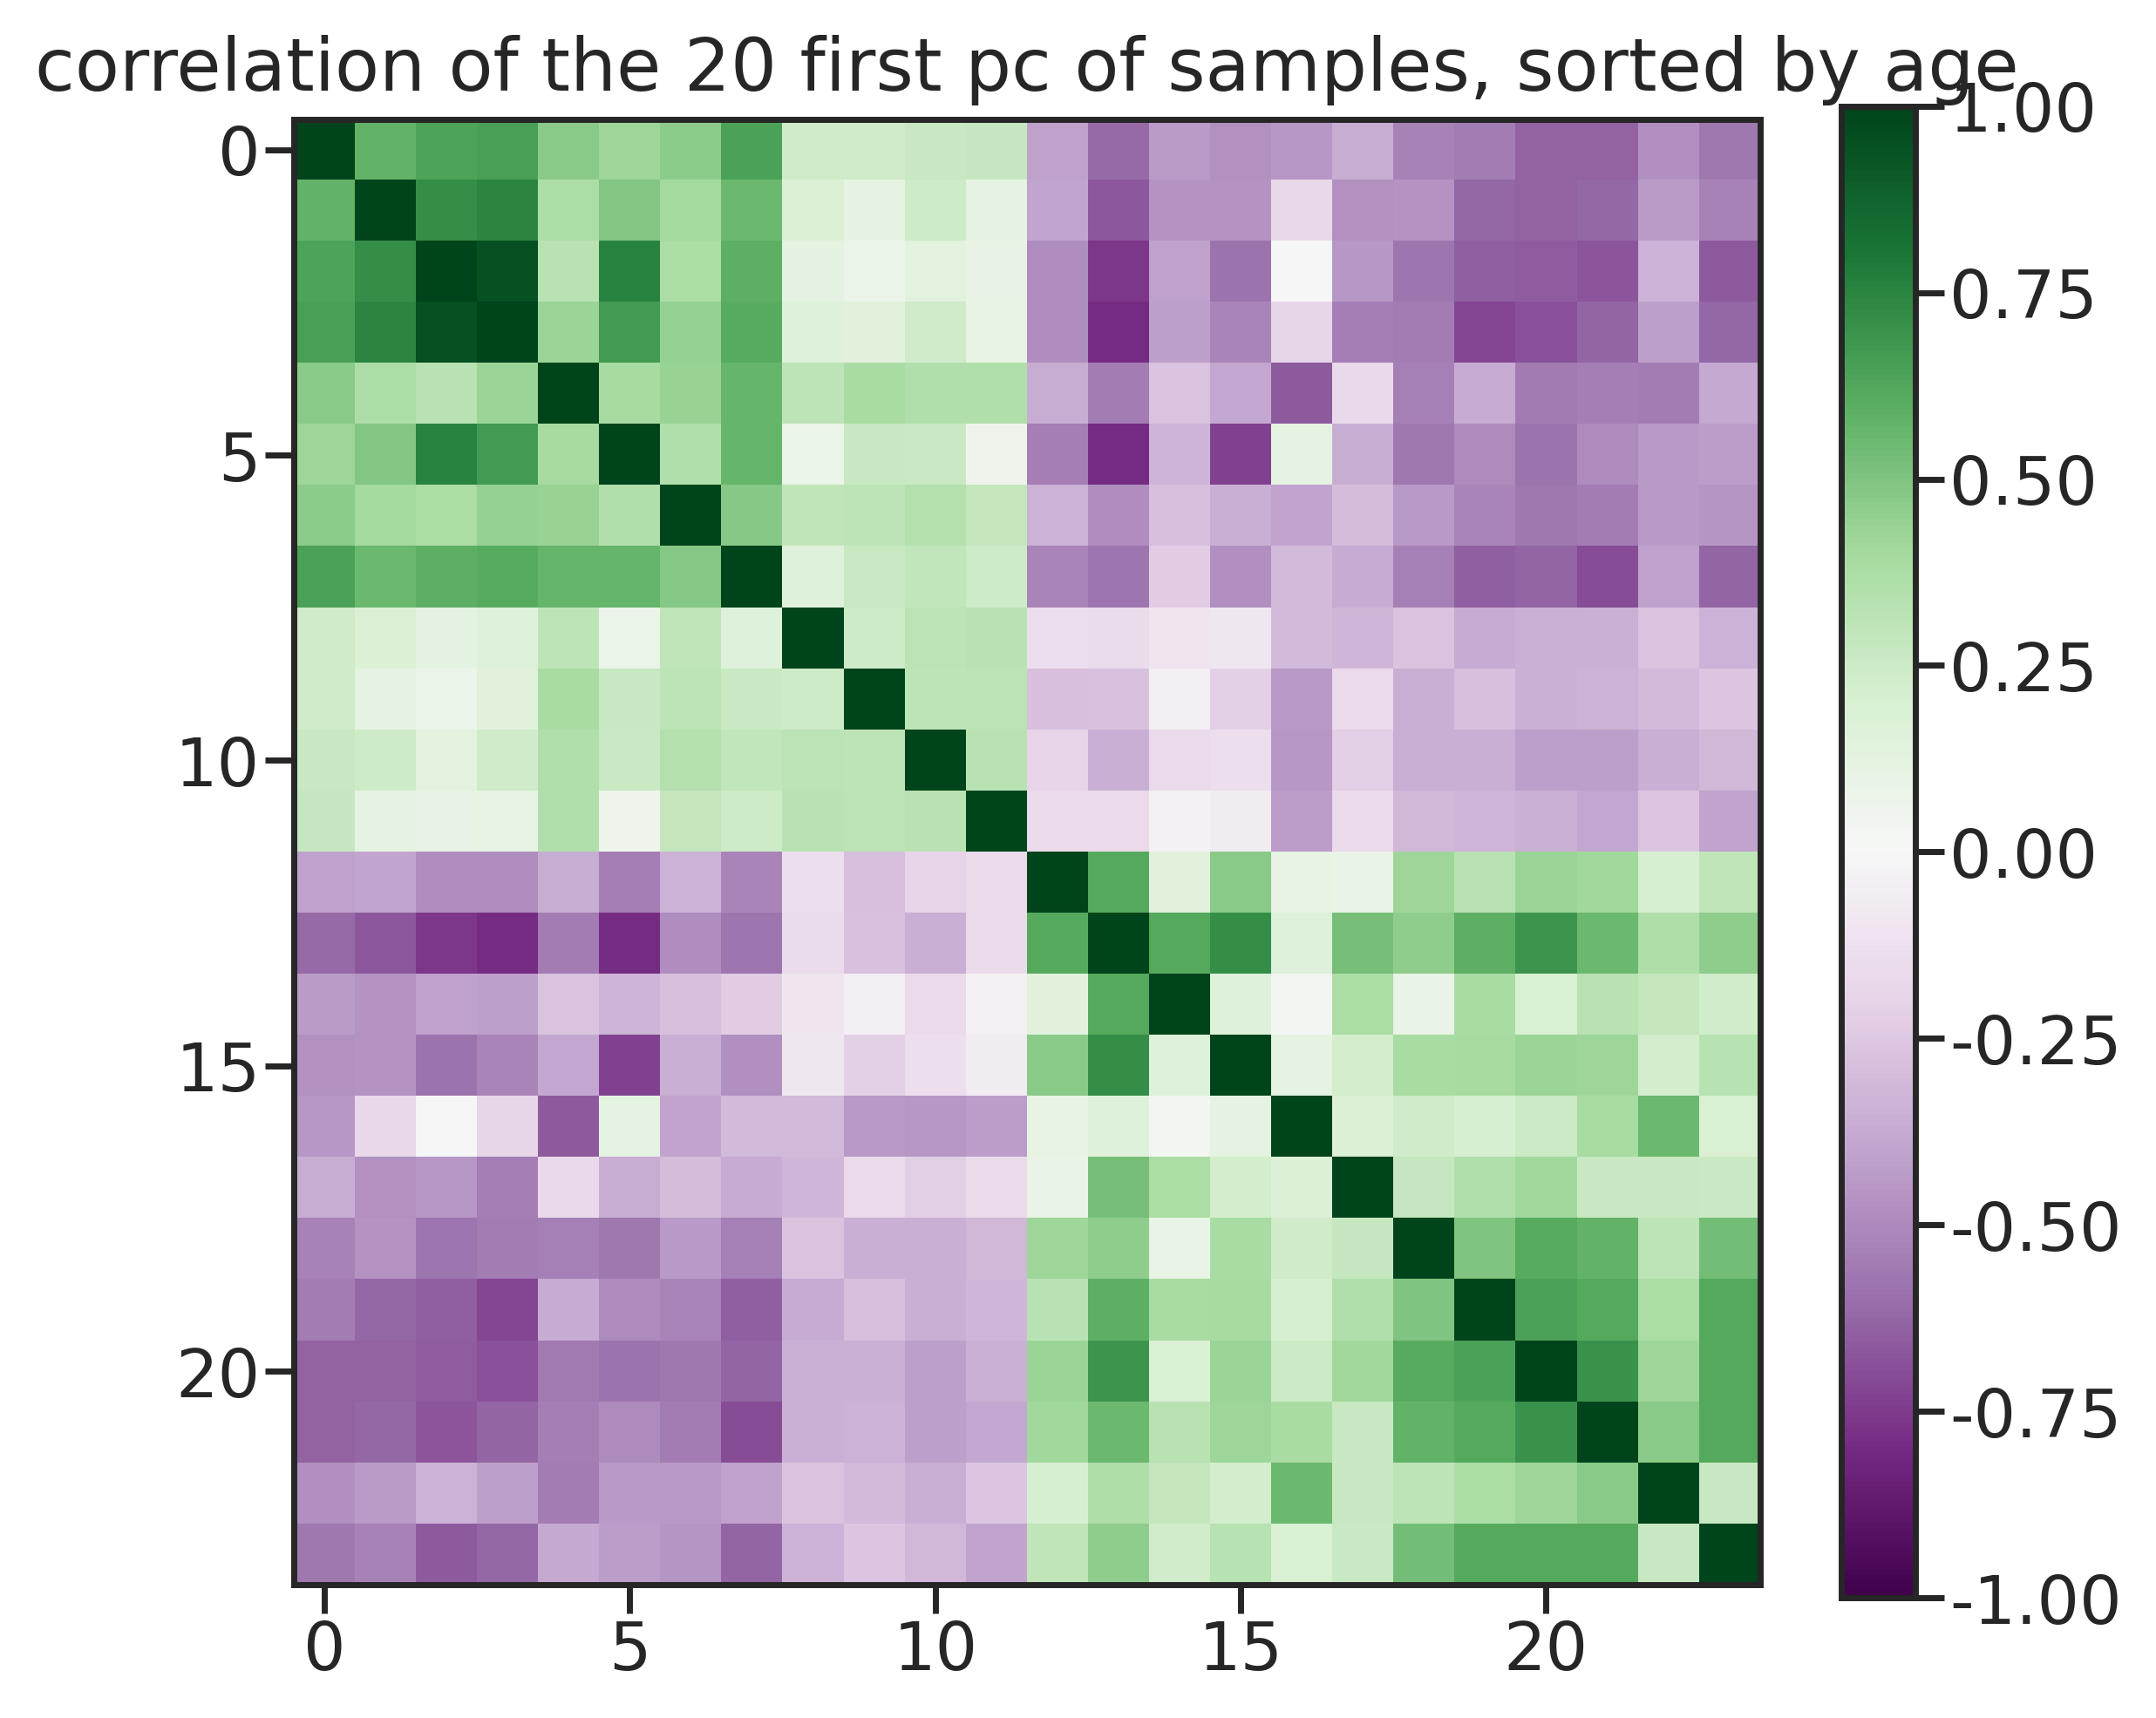

In [46]:
# plot the oc correlation between different mice, sorted by age order
dfd_pca_corr =(df_pca_dna).T.corr()

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(dfd_pca_corr, aspect="auto", 
               vmin=-1, 
               vmax=1, 
               cmap="PRGn")
ax.set_box_aspect(1)
ax. set_title ('correlation of the 20 first pc of samples, sorted by age')
plt.colorbar(im, fraction=0.046)

In [47]:
# get behavioral data only for mice that are in the samples we have
fdata = fdata[fdata.mouse_id.isin(ids)]
behavior_meta = fdata[['bio_age', 'mouse_id','uuid']].reset_index(drop=True)
behavior_meta.sort_index(inplace=True)
fdata.set_index(['bio_age', 'mouse_id','uuid'], inplace=True)
fdata.drop(columns=['mouse','age'], inplace=True)
fdata.sort_index(inplace=True)

In [48]:
# PCA the data
pca = PCA(n_components=20).fit(fdata)
X_pca_behavior = pca.transform(fdata)
dfb_pca = pd.DataFrame(X_pca_behavior)
dfb_pca = dfb_pca.join(behavior_meta)
dfb_pca.set_index(['bio_age','mouse_id','uuid'], inplace=True)
dfb_pca.sort_index(inplace=True)

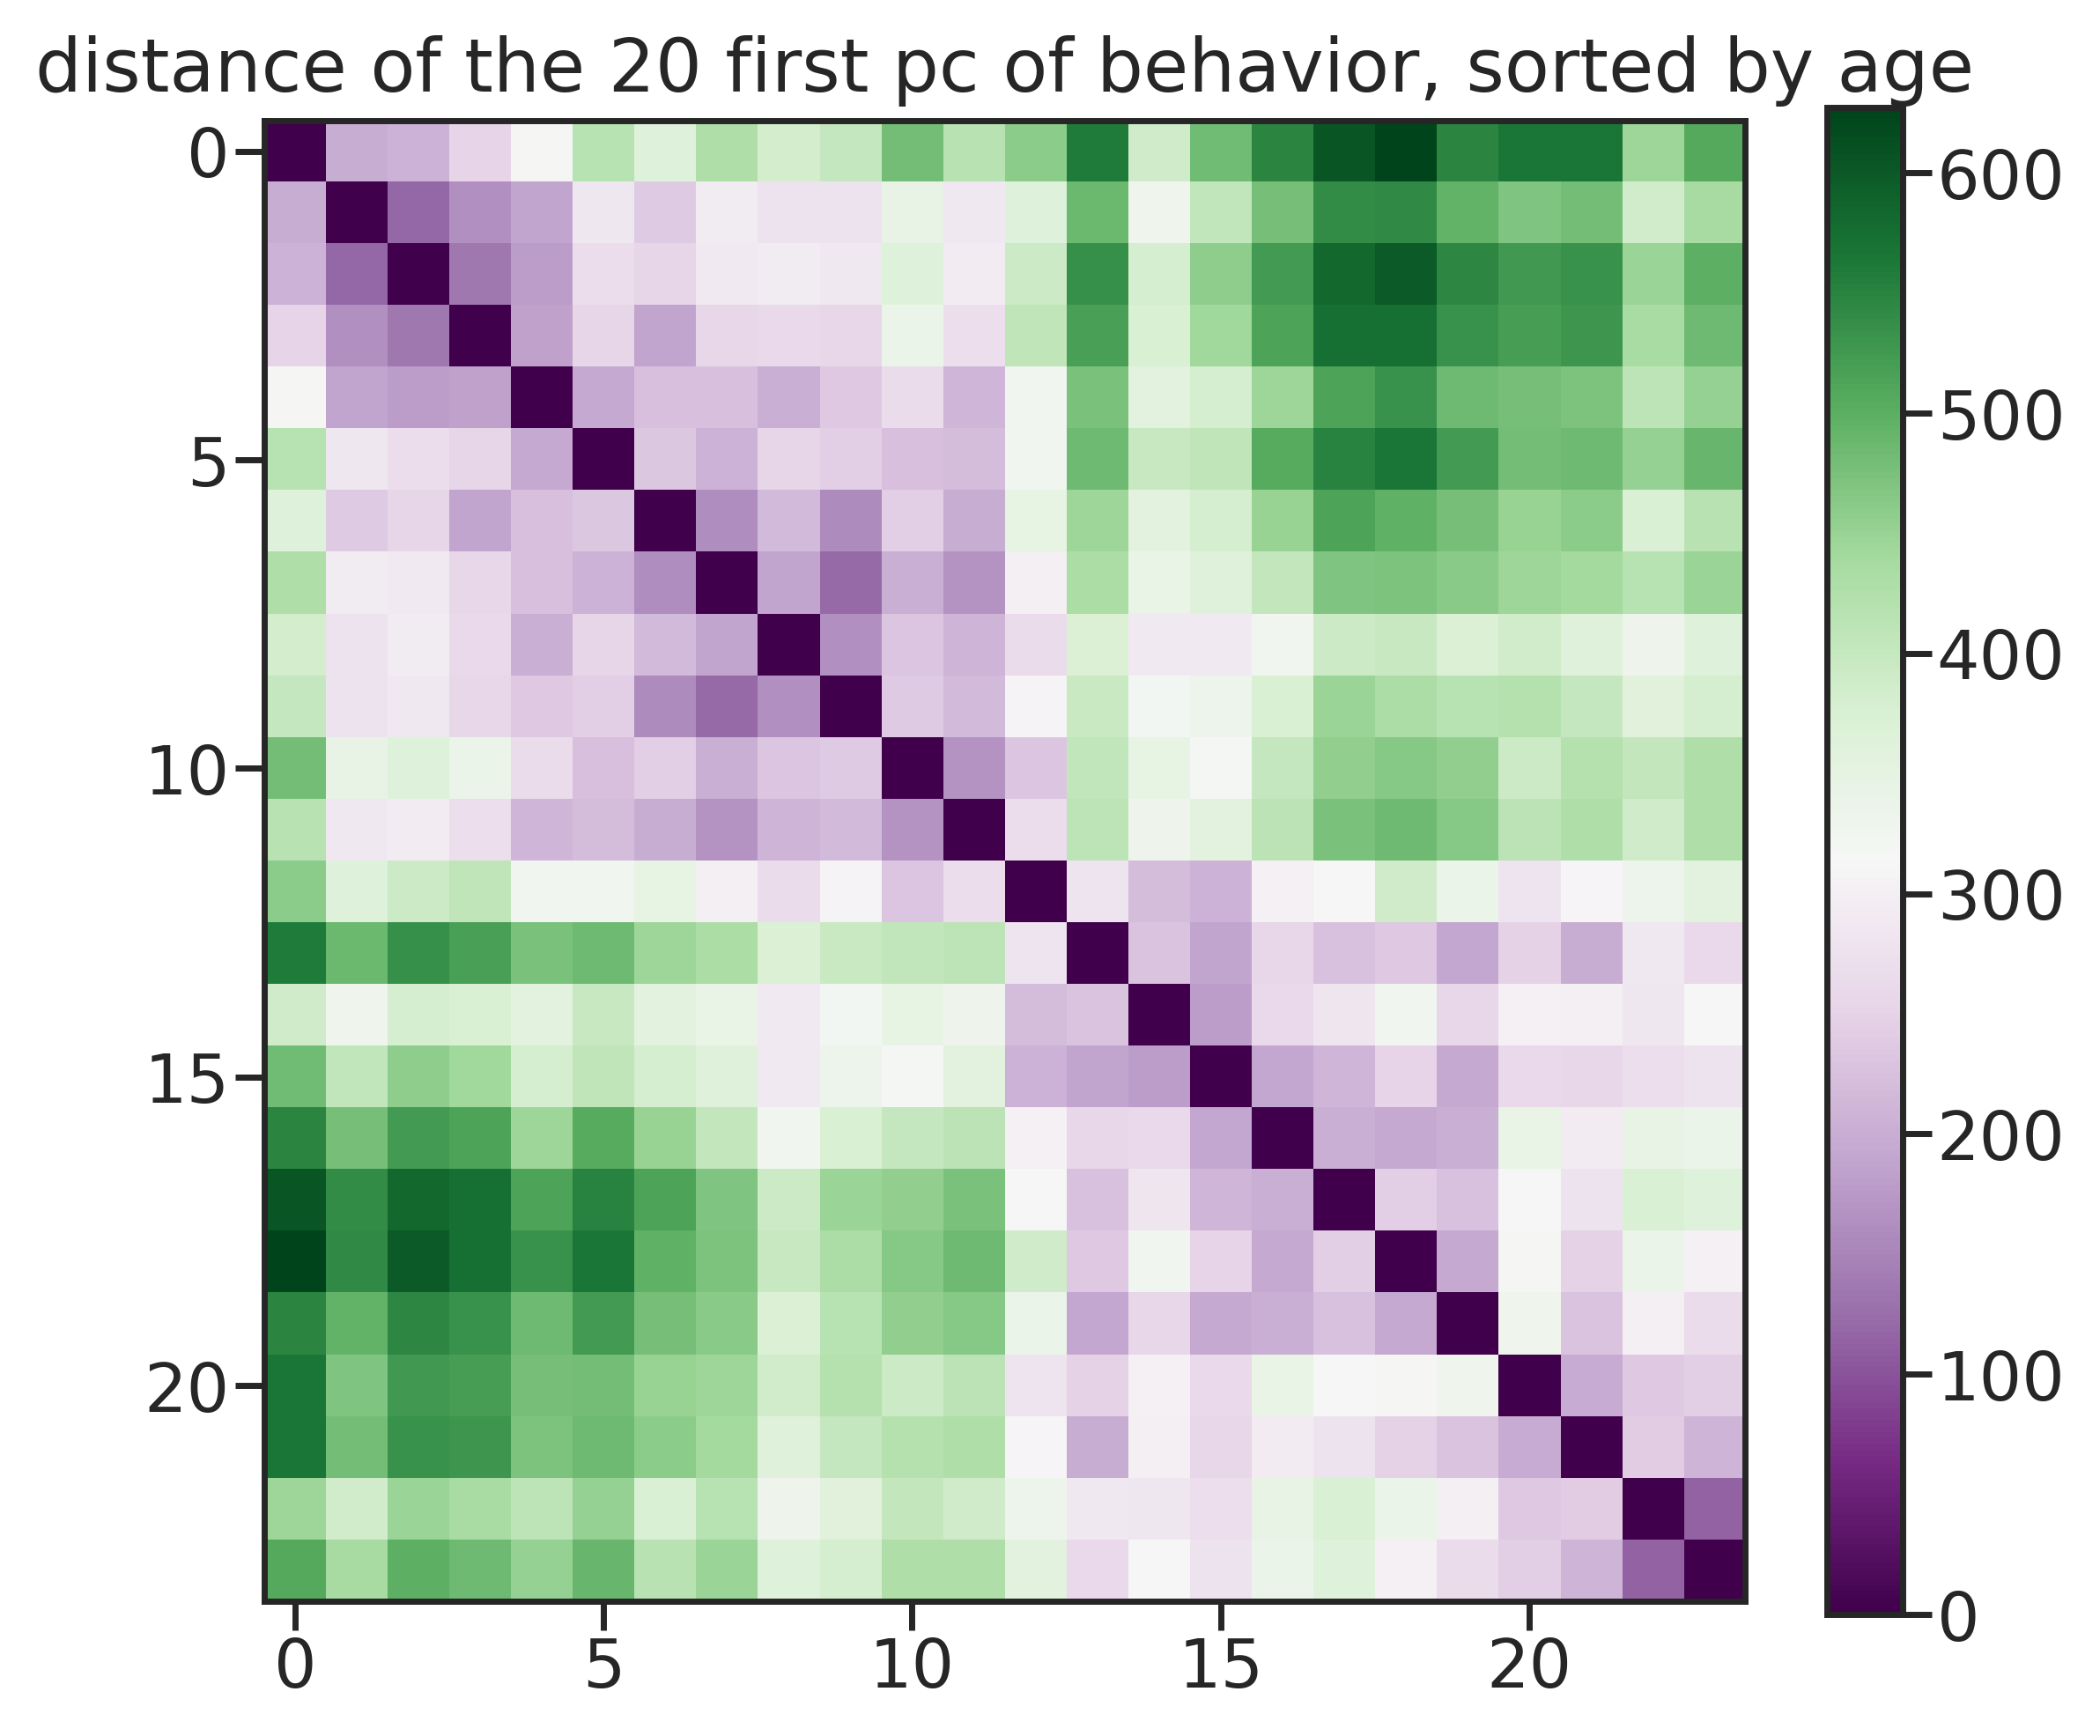

In [49]:
# plot the oc correlation between different mice, sorted by age order
dfb_pca_corr = pairwise_distances(dfb_pca)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(dfb_pca_corr, aspect="auto", 
               #vmin=-1, 
               #vmax=1, 
               cmap="PRGn")
ax.set_box_aspect(1)
ax. set_title ('distance of the 20 first pc of behavior, sorted by age')
plt.colorbar(im, fraction=0.046)

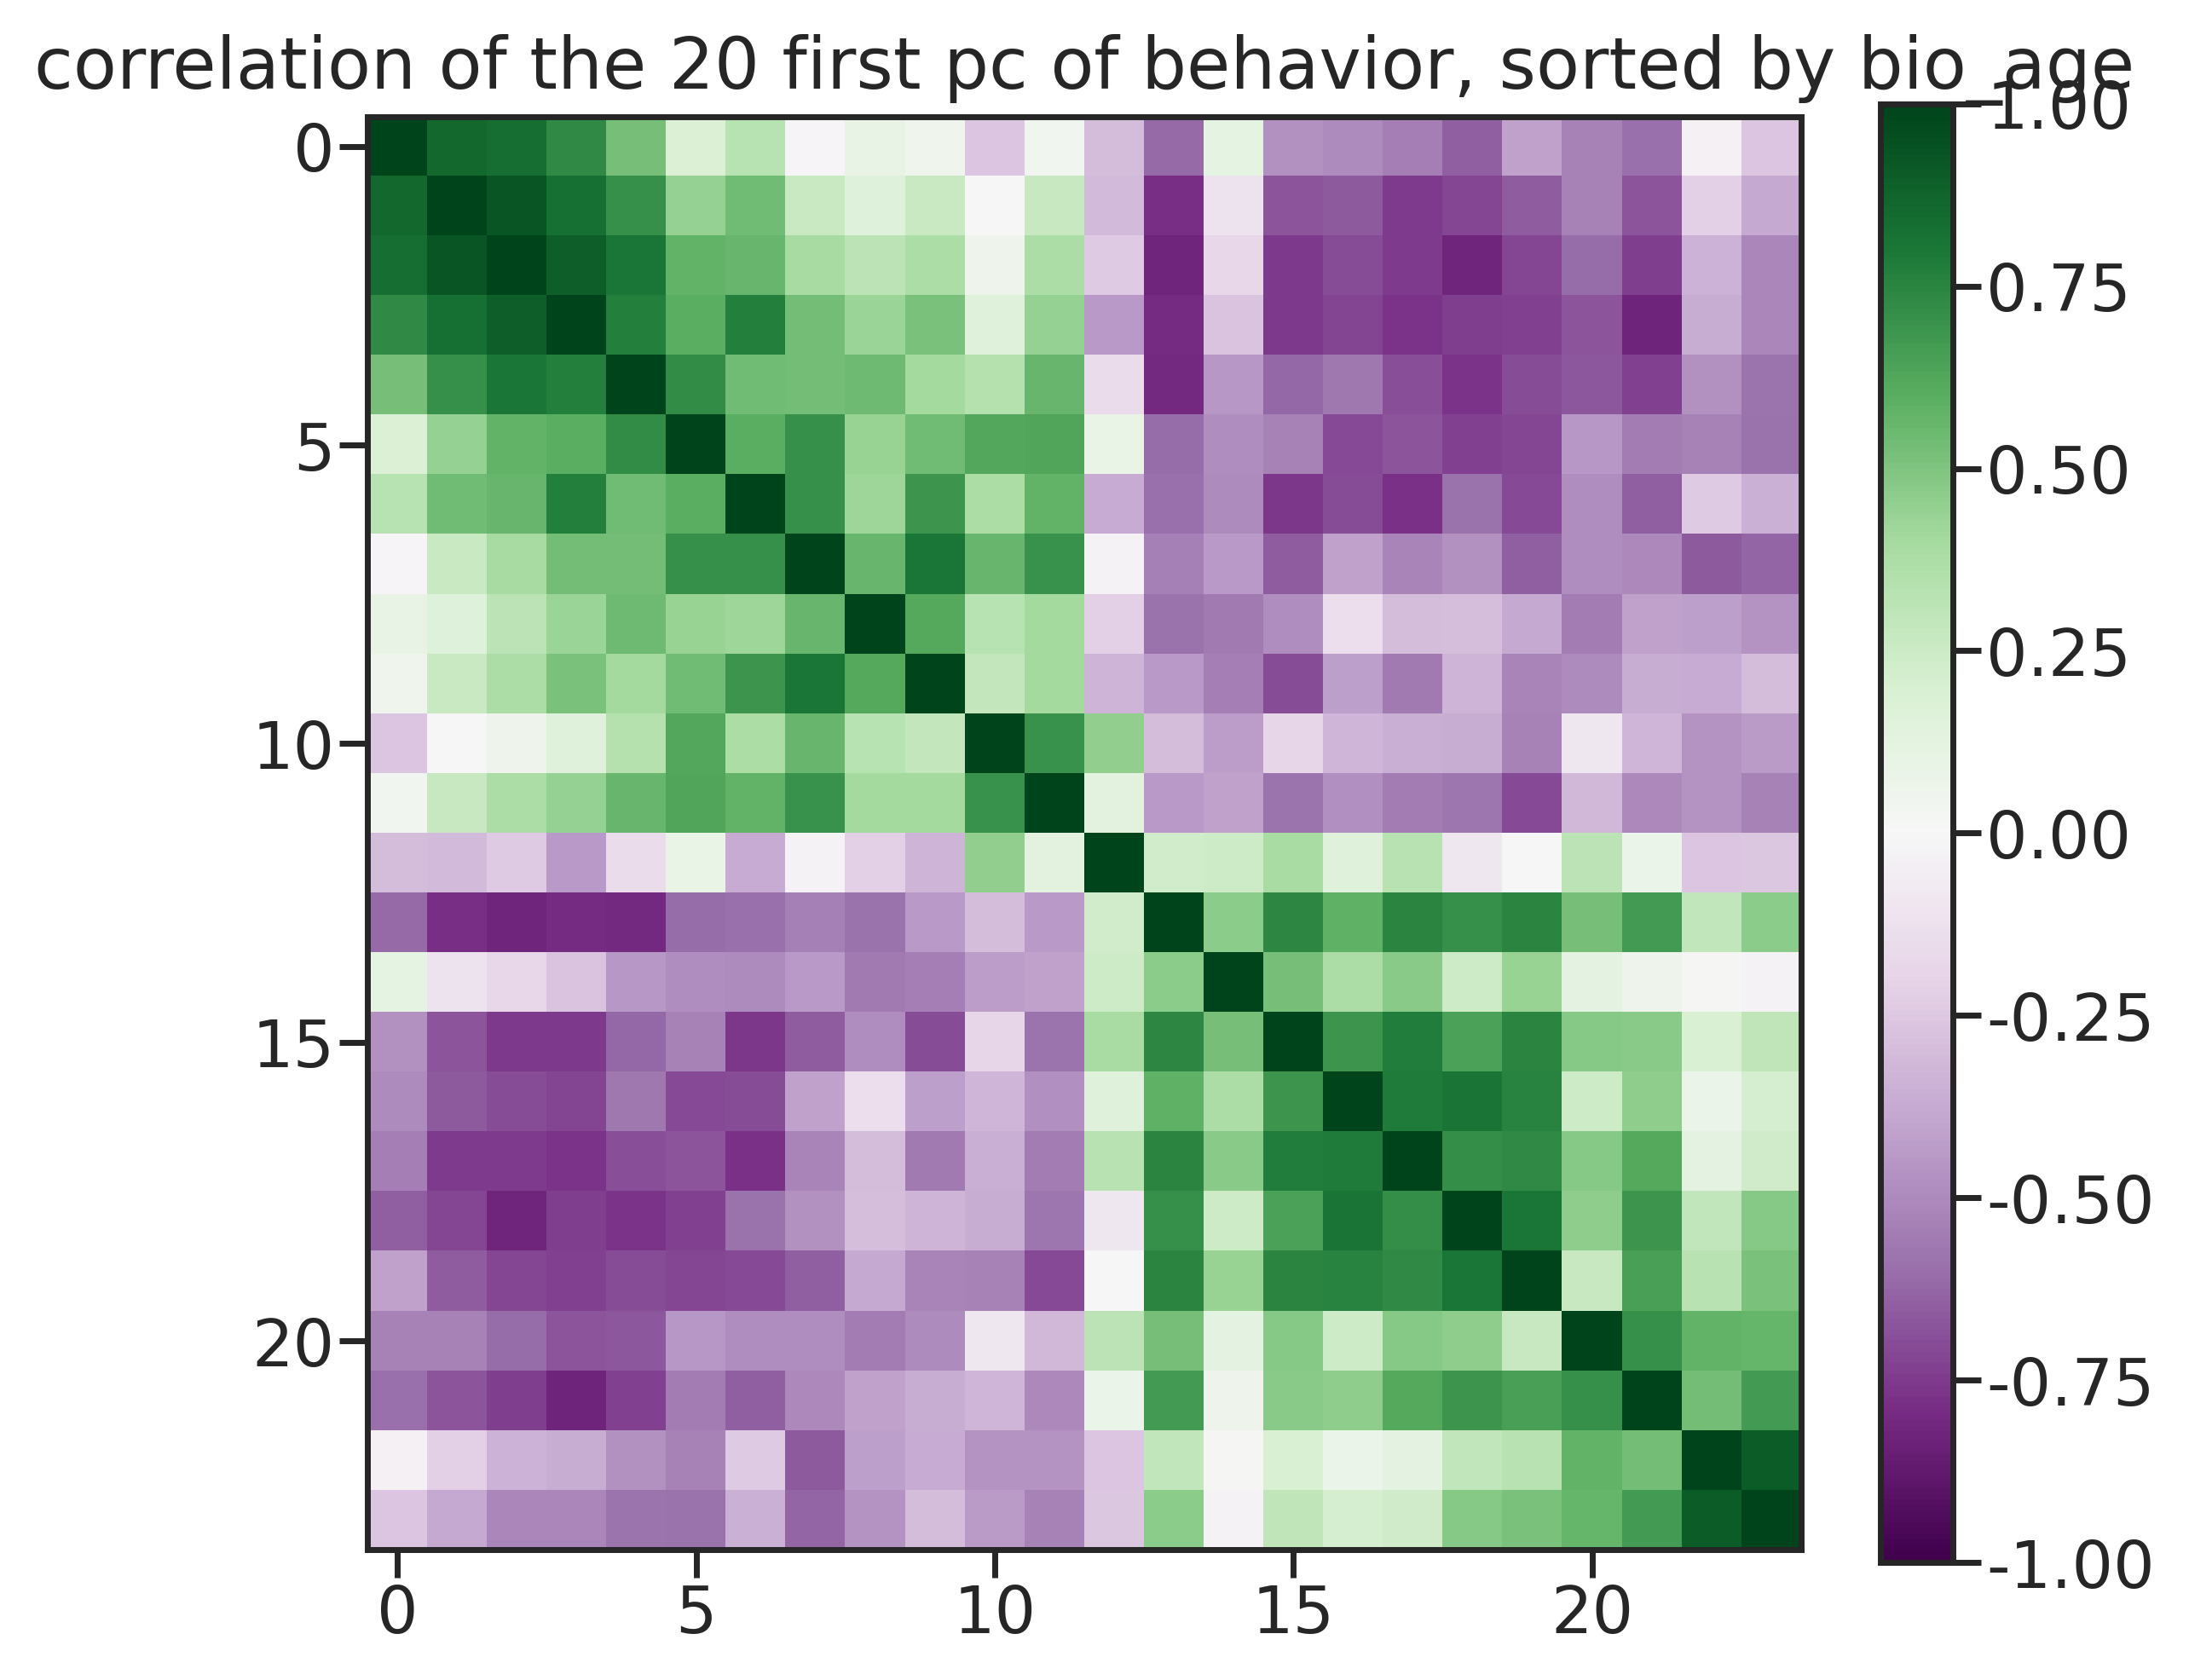

In [50]:
# plot the oc correlation between different mice, sorted by age order
dfb_pca_corr = dfb_pca.T.corr()
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(dfb_pca_corr, aspect="auto", 
               vmin=-1, 
                vmax=1, 
               cmap="PRGn")
ax.set_box_aspect(1)
ax. set_title ('correlation of the 20 first pc of behavior, sorted by bio_age')
plt.colorbar(im, fraction=0.046)

In [51]:
## rank order of mice in epiclock vs behavioral clock

In [52]:
# get dataframe of epi data with uuids of beahvioral data
temp = pd.merge(df_pca_dna, dfb_pca, left_index=True, right_index=True, how='inner')
df_pca_dna['uuid'] = temp.index.get_level_values('uuid')
df_pca_dna.set_index('uuid',append='True', inplace=True)

In [53]:
# epiclock age prediction per mouse id
temp = df_age_pred.join(df_meta_merge).reset_index()
epi=temp[['mouse_id','age','weeks','rc']].sort_values(by='age').reset_index(drop=True)
epi['epi_rank'] = epi['weeks'].rank()

In [54]:
temp = dfb_pca.reset_index()
bio_age = temp[['bio_age','mouse_id']]
bio_age['behavioral_age'] =bio_age['bio_age']
bio_age['behavioral_rank'] = bio_age['behavioral_age'].rank()
beh = bio_age[['mouse_id','behavioral_age','behavioral_rank']]

/tmp/ipykernel_27480/3738205337.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bio_age['behavioral_age'] =bio_age['bio_age']
/tmp/ipykernel_27480/3738205337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bio_age['behavioral_rank'] = bio_age['behavioral_age'].rank()


In [55]:
age_pred = pd.merge(epi,beh,on='mouse_id', suffixes=('_epi', '_age'))

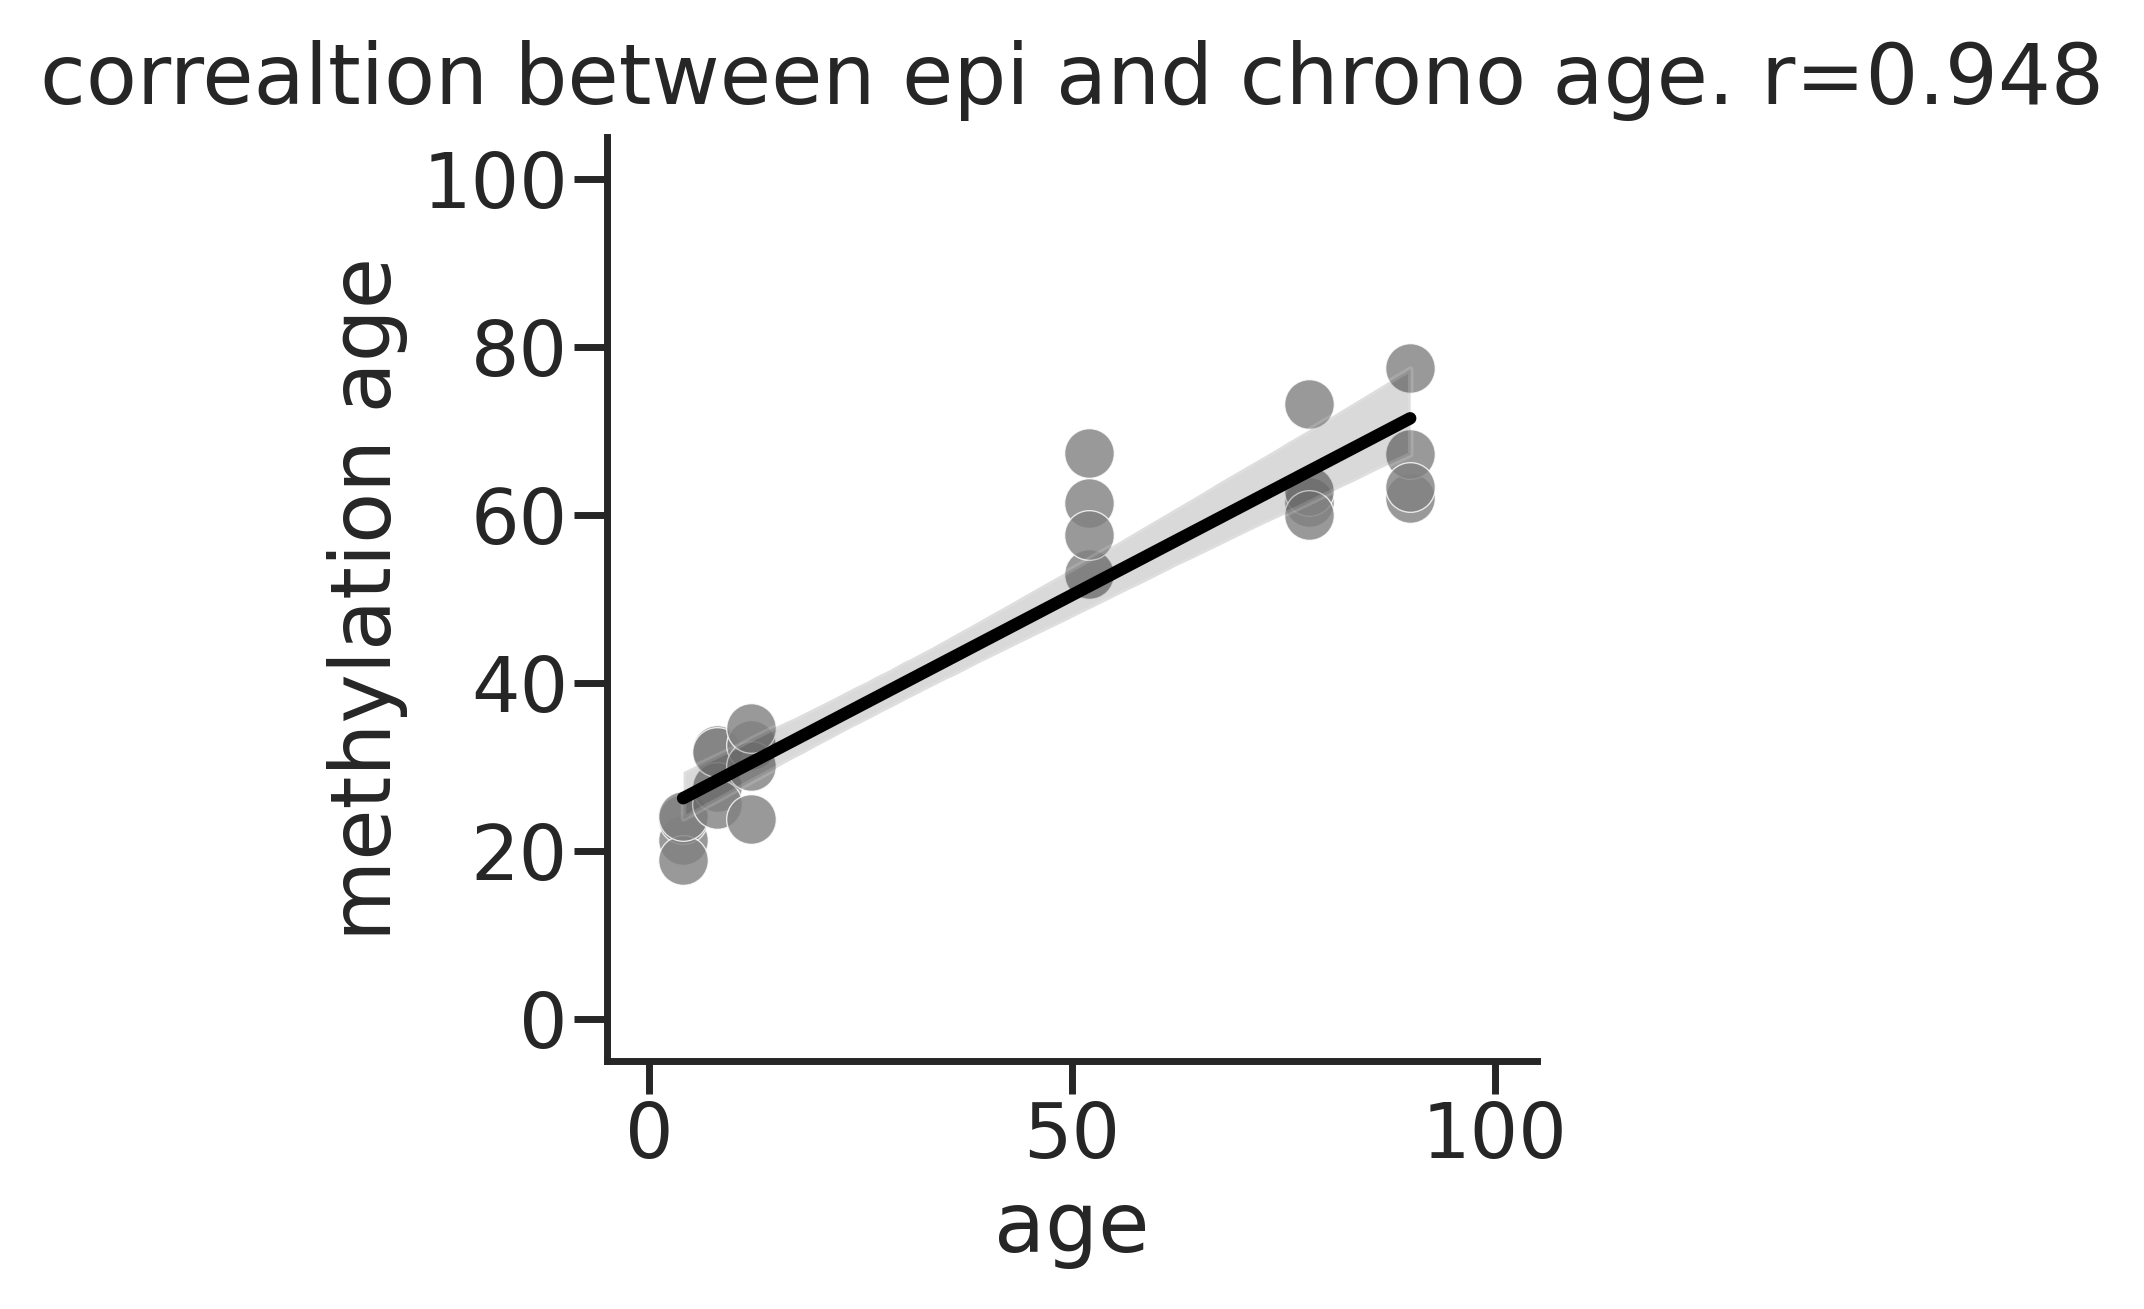

In [56]:
b = age_pred.age.to_numpy()
d= age_pred.weeks.to_numpy()
fig, ax = plt.subplots(figsize=(3,3))
sns.scatterplot(x=b,y=d,s=80, alpha=0.8,color='gray',edgecolors='black', linewidth=0.25)
[cm,pm] = stats.pearsonr(b, d)
ax.set_ylim([-5,105])
ax.set_xlim([-5,105])
ax.set_ylabel('methylation age')
ax.set_xlabel('age')
sns.despine()

ax = sns.regplot(x=b,y=d,
                 scatter=False, 
                 color='black',
                 logx=False,
                 fit_reg=True,
                )
ax.set_title('correaltion between epi and chrono age. r=' + f"{cm:.3f}")
fig.savefig(c.dana_save_path / "fig5"/ 'corr_epi_age_chrono_age.pdf')

Text(0.5, 1.0, 'correaltion between epi and bio_age. r=0.750')

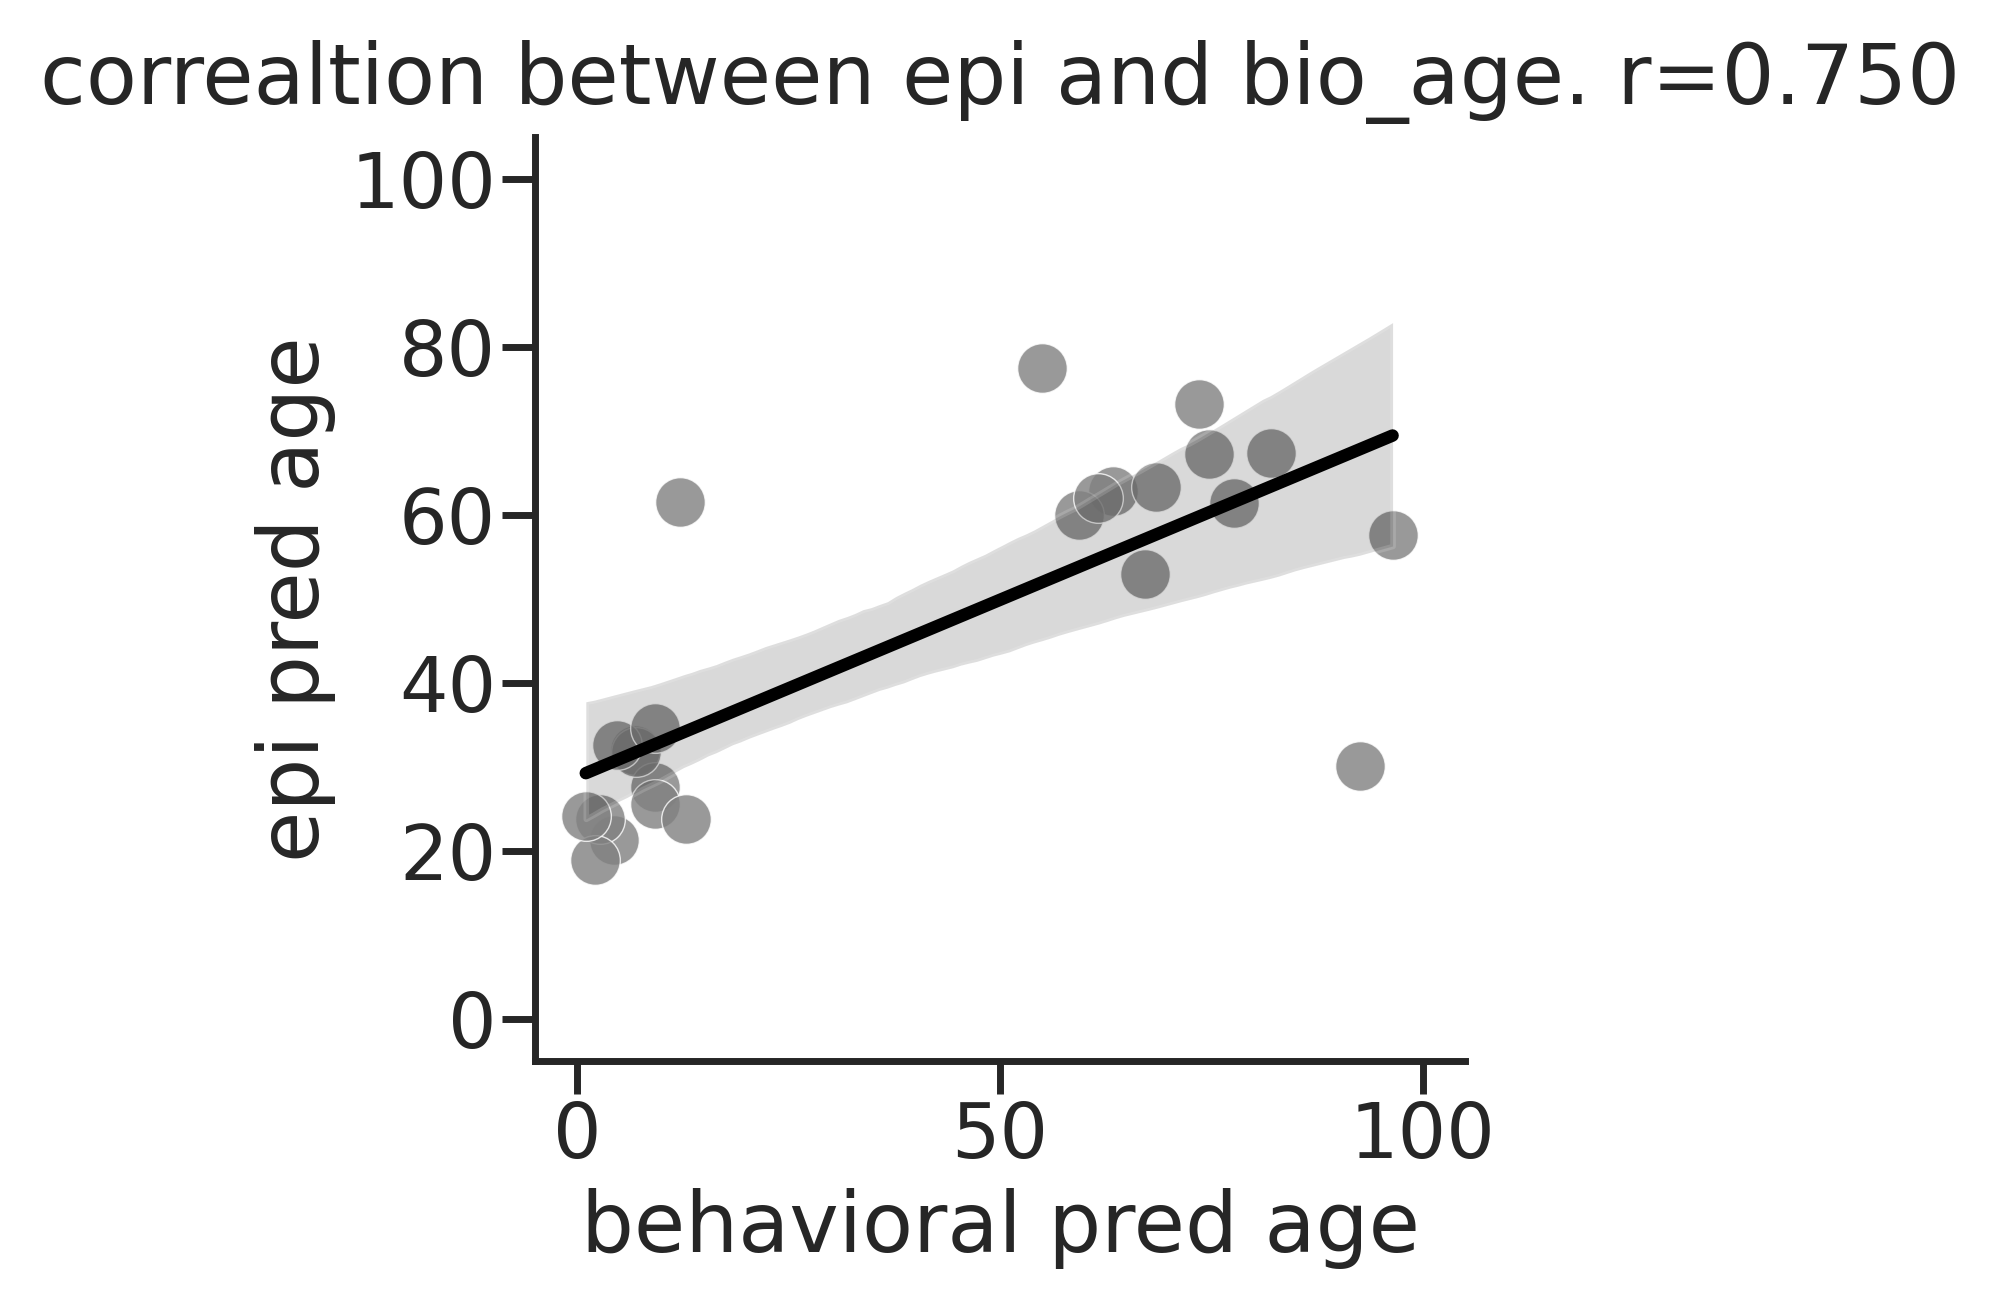

In [57]:
b = age_pred.behavioral_age.to_numpy()
d= age_pred.weeks.to_numpy()
fig, ax = plt.subplots(figsize=(3,3))
sns.scatterplot(x=b,y=d,s=80, alpha=0.8,color='gray',edgecolors='black', linewidth=0.25)
[cm,pm] = stats.pearsonr(b, d)
ax.set_ylim([-5,105])
ax.set_xlim([-5,105])
ax.set_ylabel('epi pred age')
ax.set_xlabel('behavioral pred age')
sns.despine()

ax = sns.regplot(x=b,y=d,
                 scatter=False, 
                 color='black',
                 logx=False,
                 fit_reg=True,
                )
ax.set_title('correaltion between epi and bio_age. r=' + f"{cm:.3f}")

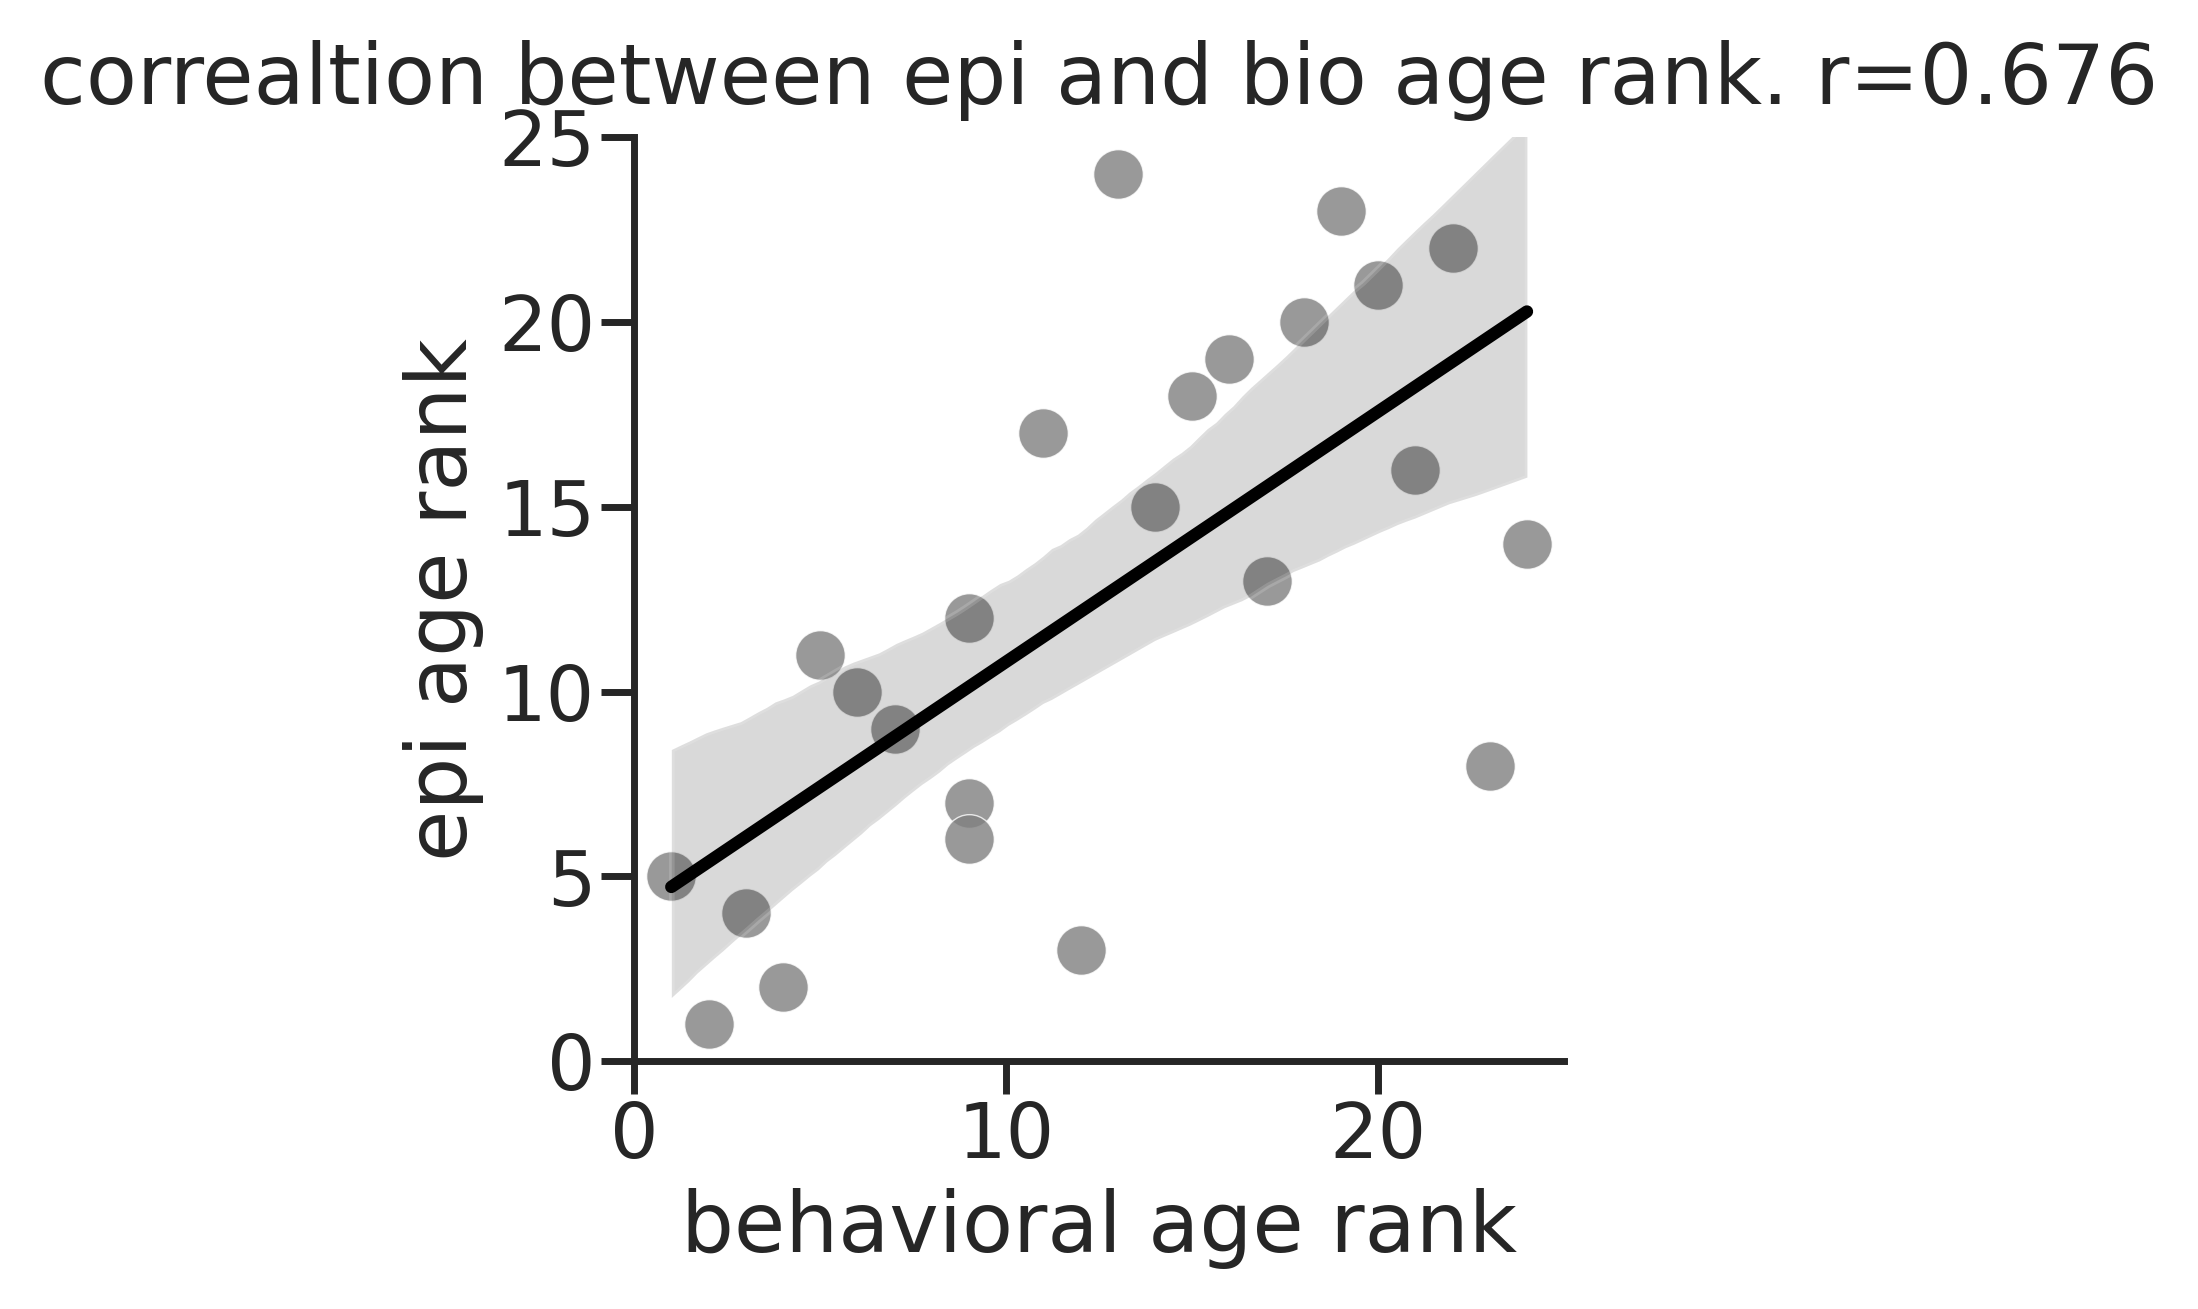

In [58]:
b = age_pred.behavioral_rank.to_numpy()
d= age_pred.epi_rank.to_numpy()
fig, ax = plt.subplots(figsize=(3,3))
sns.scatterplot(x=b,y=d,s=80, alpha=0.8,color='gray',edgecolors='black', linewidth=0.25)
[cm,pm] = stats.pearsonr(b, d)
ax.set_ylim([0,25])
ax.set_xlim([0,25])
ax.set_ylabel('epi age rank')
ax.set_xlabel('behavioral age rank')
sns.despine()

ax = sns.regplot(x=b,y=d,
                 scatter=False, 
                 color='black',
                 logx=False,
                 fit_reg=True,
                )
ax.set_title('correaltion between epi and bio age rank. r=' + f"{cm:.3f}")
fig.savefig(c.dana_save_path / "fig5"/ 'corr_epi_rank_bio_rank.pdf')

Text(0.5, 1.0, 'correaltion between epi and chro age rank. r=0.893')

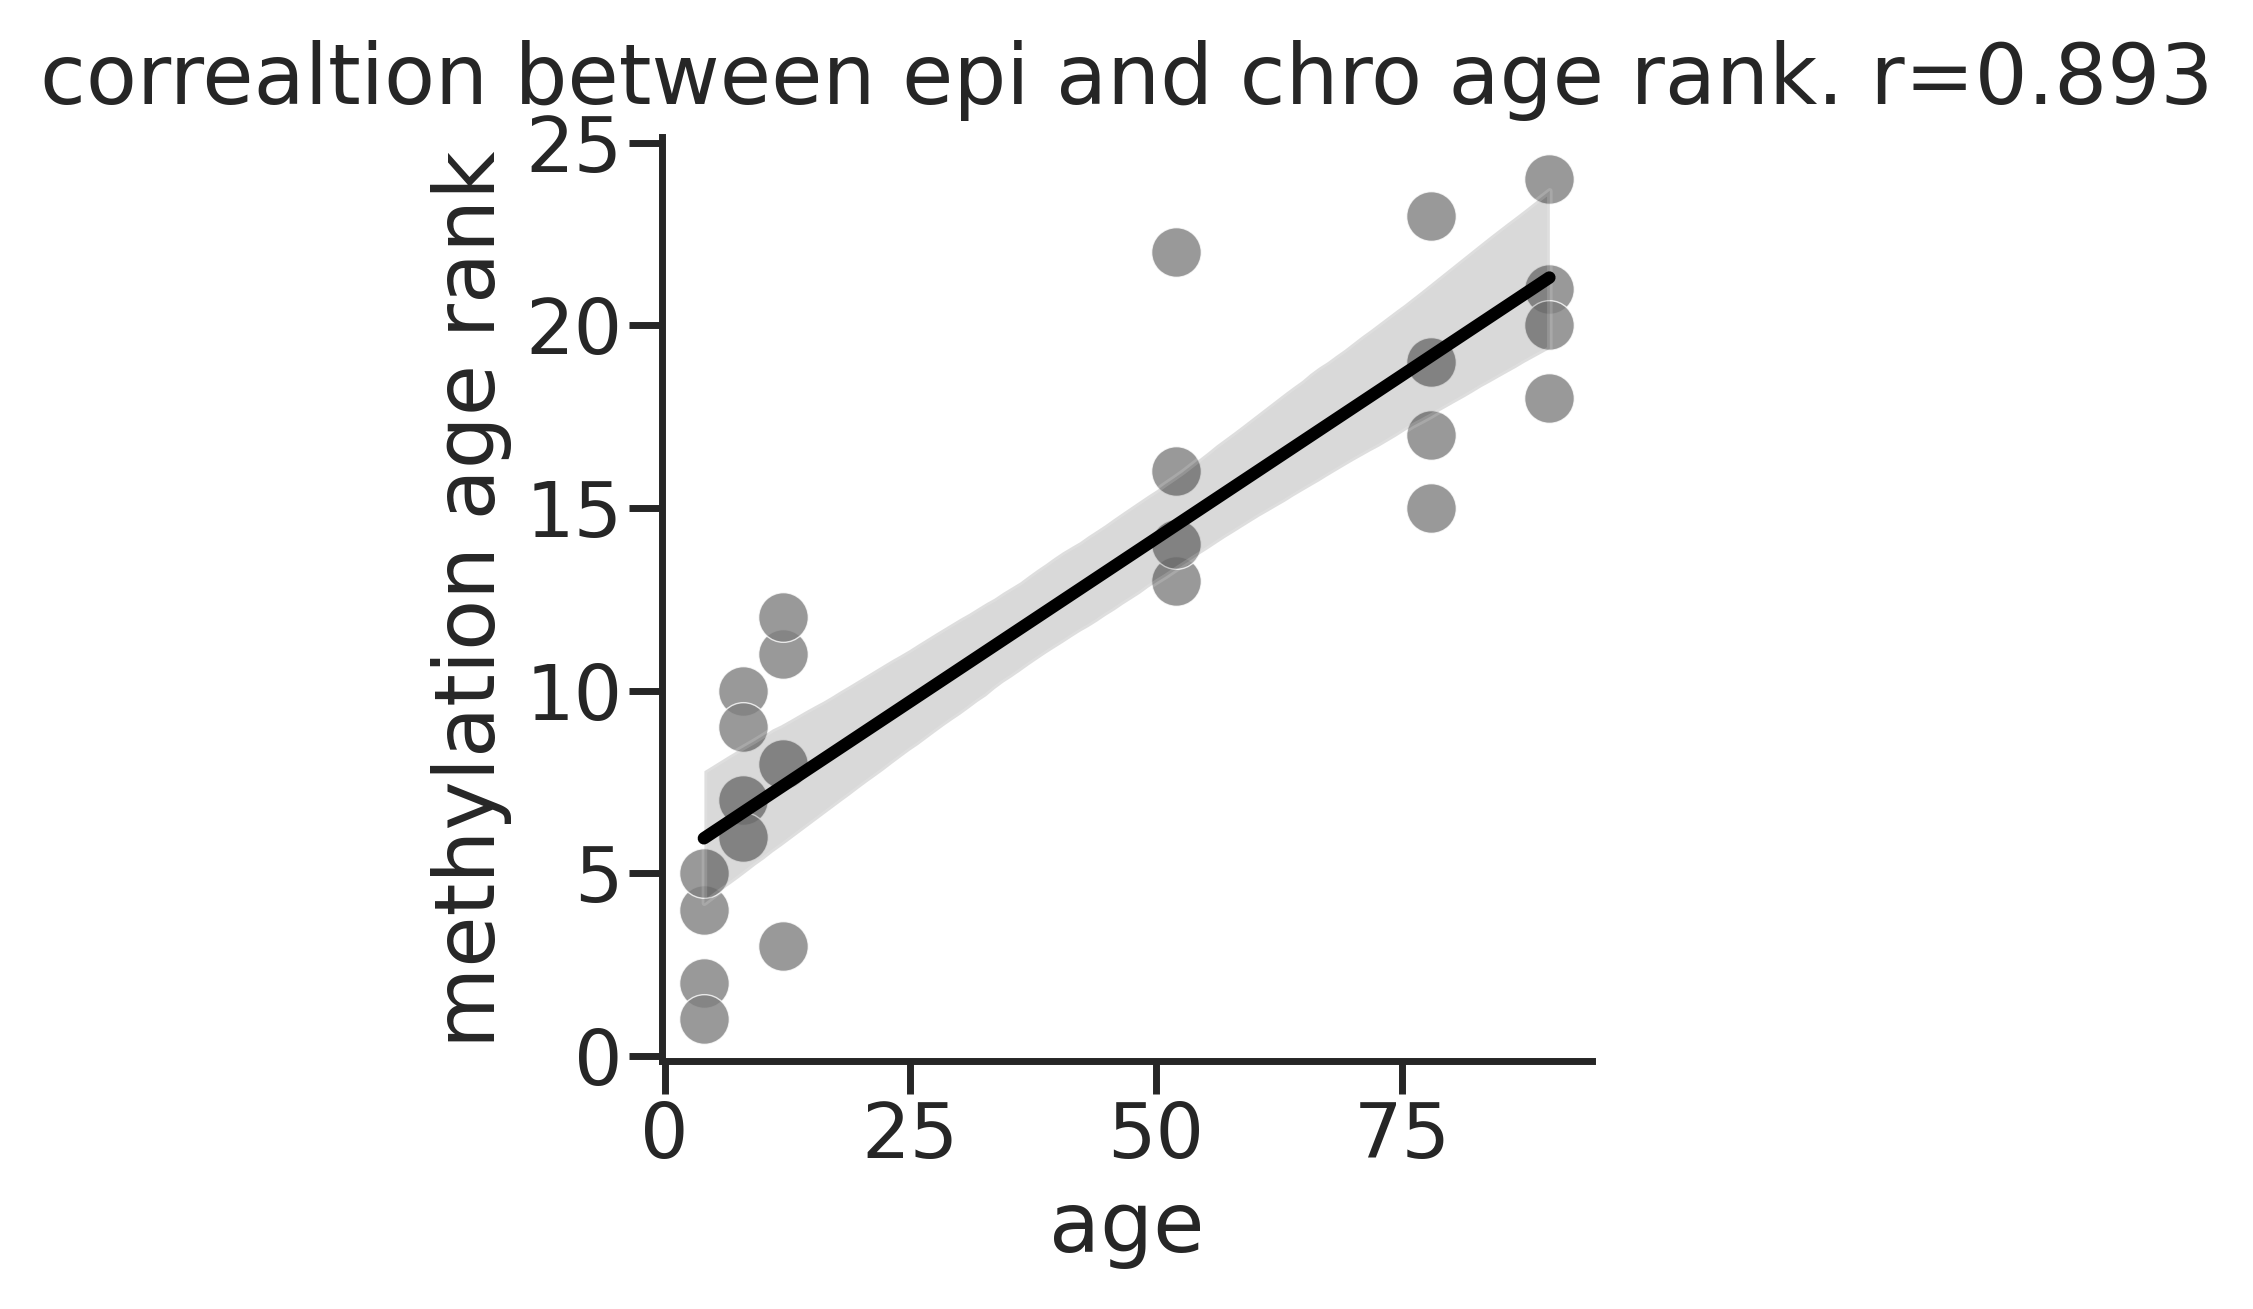

In [59]:
b = age_pred.age.to_numpy()
d= age_pred.epi_rank.to_numpy()
fig, ax = plt.subplots(figsize=(3,3))
sns.scatterplot(x=b,y=d,s=80, alpha=0.8,color='gray',edgecolors='black', linewidth=0.25)
[cm,pm] = stats.pearsonr(b, d)
#ax.set_ylim([0,25])
#ax.set_xlim([0,25])
ax.set_ylabel('methylation age rank')
ax.set_xlabel('age')
sns.despine()

ax = sns.regplot(x=b,y=d,
                 scatter=False, 
                 color='black',
                 logx=False,
                 fit_reg=True,
                )
ax.set_title('correaltion between epi and chro age rank. r=' + f"{cm:.3f}")

In [60]:
sns.despine()
fig.savefig(c.dana_save_path / "fig5"/ 'corr_epi_rank_chrono_age.pdf')

<Figure size 600x600 with 0 Axes>